<a href="https://colab.research.google.com/github/AntonDozhdikov/politpredict/blob/main/MADDPG_GDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Оптимизированная система Darwin Gödel MADDPG для Google Colab ЦП или  T4 GPU
Включает счетчик времени, сохранение метрик и расширенную визуализацию
"""

'\nОптимизированная система Darwin Gödel MADDPG для Google Colab T4 GPU\nВключает счетчик времени, сохранение метрик и расширенную визуализацию\n'

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import time
from datetime import datetime, timedelta
import copy
import os
from typing import List, Dict, Tuple, Optional
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ===== НАСТРОЙКИ ОПТИМИЗАЦИИ ДЛЯ GOOGLE COLAB T4 GPU =====
print("🚀 Инициализация оптимизаций для Google Colab T4...")

# Проверка доступности GPU и настройка CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"✅ GPU доступен: {torch.cuda.get_device_name(0)}")
    # Оптимизация для T4 GPU
    torch.backends.cudnn.benchmark = True  # Включение cuDNN автотюнера
    torch.backends.cudnn.deterministic = False  # Для лучшей производительности
    torch.cuda.empty_cache()  # Очистка кэша GPU

    # Настройки памяти для T4 (15GB VRAM)
    torch.cuda.set_per_process_memory_fraction(0.9)  # Использование 90% памяти GPU
    print(f"📊 Доступная память GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ GPU не доступен, используется CPU")

# Настройка matplotlib для лучшего отображения в Colab
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.style.use('seaborn-v0_8')

🚀 Инициализация оптимизаций для Google Colab T4...
⚠️ GPU не доступен, используется CPU


In [4]:
# ===== ГИПЕРПАРАМЕТРЫ СИСТЕМЫ =====
# Основные параметры (НЕ ИЗМЕНЯЮТСЯ)
NUM_REGIONS_STAGE1 = 7
NUM_REGIONS_STAGE2 = 28
NUM_REGIONS_STAGE3 = 89
EPISODES_PER_STAGE = 42
STEPS = 200
BATCH_SIZE = 64  # Оптимизировано для T4
GAMMA = 0.95
TAU = 0.01
LR_ACTOR = 0.001
LR_CRITIC = 0.002
HIDDEN_SIZE = 64

# Параметры Darwin Gödel Machine (НЕ ИЗМЕНЯЮТСЯ)
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.3
SELECTION_PRESSURE = 0.7
ARCHITECTURE_POOL_SIZE = 100
EVOLUTION_FREQUENCY = 5

# Настройки оптимизации для T4 GPU
NUM_WORKERS = 2  # Оптимально для T4 в Colab
PIN_MEMORY = True if torch.cuda.is_available() else False
PERSISTENT_WORKERS = True

# Обеспечение воспроизводимости
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("🔧 Оптимизации загружены успешно!")

🔧 Оптимизации загружены успешно!


In [5]:
# ===== КЛАСС МОНИТОРИНГА ВРЕМЕНИ ВЫПОЛНЕНИЯ =====
class TimeTracker:
    """
    Продвинутый трекер времени выполнения для каждой стадии
    """
    def __init__(self, colab_time_limit_hours: float = 12.0):
        self.colab_time_limit = colab_time_limit_hours * 3600  # Переводим в секунды
        self.session_start_time = time.time()
        self.stage_start_time = None
        self.stage_history = []
        self.current_stage = None

    def start_stage(self, stage_name: str, episodes_count: int):
        """Начало отслеживания стадии"""
        self.stage_start_time = time.time()
        self.current_stage = {
            'name': stage_name,
            'start_time': self.stage_start_time,
            'episodes_total': episodes_count,
            'episodes_completed': 0,
            'estimated_duration': None,
            'remaining_time': None
        }
        print(f"\n🎯 Начало стадии: {stage_name}")
        print(f"📅 Время начала: {datetime.now().strftime('%H:%M:%S')}")

    def update_progress(self, episodes_completed: int):
        """Обновление прогресса стадии"""
        if self.current_stage is None:
            return

        self.current_stage['episodes_completed'] = episodes_completed

        # Расчет оставшегося времени
        elapsed_time = time.time() - self.stage_start_time
        if episodes_completed > 0:
            time_per_episode = elapsed_time / episodes_completed
            remaining_episodes = self.current_stage['episodes_total'] - episodes_completed
            estimated_remaining = time_per_episode * remaining_episodes
            self.current_stage['estimated_duration'] = elapsed_time + estimated_remaining
            self.current_stage['remaining_time'] = estimated_remaining

    def get_time_info(self) -> Dict:
        """Получение информации о времени"""
        current_time = time.time()
        session_elapsed = current_time - self.session_start_time
        session_remaining = max(0, self.colab_time_limit - session_elapsed)

        info = {
            'session_elapsed': session_elapsed,
            'session_remaining': session_remaining,
            'session_progress': (session_elapsed / self.colab_time_limit) * 100,
            'colab_timeout_risk': session_remaining < 1800  # Риск если меньше 30 минут
        }

        if self.current_stage:
            stage_elapsed = current_time - self.stage_start_time
            info.update({
                'stage_name': self.current_stage['name'],
                'stage_elapsed': stage_elapsed,
                'stage_remaining': self.current_stage.get('remaining_time', 0),
                'episodes_completed': self.current_stage['episodes_completed'],
                'episodes_total': self.current_stage['episodes_total'],
                'stage_progress': (self.current_stage['episodes_completed'] /
                                 self.current_stage['episodes_total']) * 100
            })

        return info

    def finish_stage(self):
        """Завершение текущей стадии"""
        if self.current_stage:
            finish_time = time.time()
            duration = finish_time - self.stage_start_time
            self.current_stage['finish_time'] = finish_time
            self.current_stage['total_duration'] = duration
            self.stage_history.append(copy.deepcopy(self.current_stage))

            print(f"✅ Стадия '{self.current_stage['name']}' завершена")
            print(f"⏱️ Длительность: {self._format_time(duration)}")
            self.current_stage = None

    def display_status(self):
        """Отображение текущего статуса времени"""
        info = self.get_time_info()

        print("\n" + "="*70)
        print("⏰ СТАТУС ВРЕМЕНИ ВЫПОЛНЕНИЯ")
        print("="*70)

        # Информация о сессии Colab
        print(f"🖥️  Сессия Colab:")
        print(f"   Прошло времени: {self._format_time(info['session_elapsed'])}")
        print(f"   Осталось времени: {self._format_time(info['session_remaining'])}")
        print(f"   Прогресс сессии: {info['session_progress']:.1f}%")

        if info['colab_timeout_risk']:
            print("   ⚠️  ВНИМАНИЕ: Приближается лимит времени Colab!")

        # Информация о текущей стадии
        if 'stage_name' in info:
            print(f"\n🎯 Текущая стадия: {info['stage_name']}")
            print(f"   Прошло времени: {self._format_time(info['stage_elapsed'])}")
            print(f"   Осталось времени: {self._format_time(info['stage_remaining'])}")
            print(f"   Эпизоды: {info['episodes_completed']}/{info['episodes_total']}")
            print(f"   Прогресс стадии: {info['stage_progress']:.1f}%")

        print("="*70)

    def _format_time(self, seconds: float) -> str:
        """Форматирование времени в читаемый вид"""
        if seconds < 60:
            return f"{seconds:.1f}с"
        elif seconds < 3600:
            return f"{seconds/60:.1f}м"
        else:
            return f"{seconds/3600:.1f}ч {(seconds%3600)/60:.0f}м"

In [6]:
# ===== РАСШИРЕННАЯ СИСТЕМА ВИЗУАЛИЗАЦИИ =====
class EnhancedVisualization:
    """
    Улучшенная система визуализации с графиками и символами
    """
    def __init__(self):
        # Настройка стилей для красивых графиков
        plt.style.use('seaborn-v0_8-darkgrid')
        sns.set_palette("husl")

        # Эмодзи и символы для визуализации
        self.stage_symbols = {
            'stage1': '🥇',
            'stage2': '🥈',
            'stage3': '🥉'
        }

        self.metric_symbols = {
            'reward': '🎯',
            'fitness': '💪',
            'population': '👥',
            'economy': '💰',
            'resources': '🌿',
            'stability': '⚖️',
            'adaptation': '🔄',
            'entropy': '🌀',
            'efficiency': '⚡',
            'coordination': '🤝'
        }

    def create_comprehensive_dashboard(self, performance_monitor, stage_name: str):
        """Создание комплексной панели мониторинга"""
        print(f"\n📊 Создание панели мониторинга для {stage_name}...")

        # Создание фигуры с множественными подграфиками
        fig = plt.figure(figsize=(20, 16))
        gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

        # Заголовок с эмодзи
        stage_emoji = self.stage_symbols.get(stage_name.lower().replace(' ', ''), '🚀')
        fig.suptitle(f'{stage_emoji} Панель мониторинга: {stage_name}',
                     fontsize=20, fontweight='bold', y=0.95)

        metrics = performance_monitor.metrics

        # 1. Награды и системная производительность
        ax1 = fig.add_subplot(gs[0, :2])
        if metrics['episode_rewards']:
            episodes = range(len(metrics['episode_rewards']))
            ax1.plot(episodes, metrics['episode_rewards'], 'o-', linewidth=2,
                    markersize=4, alpha=0.8, label=f"{self.metric_symbols['reward']} Награда за эпизод")
            ax1.plot(episodes, np.cumsum(metrics['episode_rewards'])/np.arange(1, len(episodes)+1),
                    '--', linewidth=2, alpha=0.7, label='📈 Средняя накопленная')
            ax1.set_title(f"{self.metric_symbols['reward']} Динамика наград", fontweight='bold')
            ax1.set_xlabel('Эпизод')
            ax1.set_ylabel('Награда')
            ax1.legend()
            ax1.grid(True, alpha=0.3)

        # 2. Системная награда
        ax2 = fig.add_subplot(gs[0, 2:])
        if metrics['system_reward']:
            ax2.plot(metrics['system_reward'], 'o-', color='green', linewidth=2,
                    markersize=4, alpha=0.8)
            ax2.set_title(f"🎯 Системная награда", fontweight='bold')
            ax2.set_xlabel('Эпизод')
            ax2.set_ylabel('Общая награда')
            ax2.grid(True, alpha=0.3)

        # 3. Демографические метрики
        ax3 = fig.add_subplot(gs[1, :2])
        demo_metrics = ['population_balance', 'demographic_stability']
        colors = ['blue', 'orange']
        for i, metric in enumerate(demo_metrics):
            if metrics[metric]:
                symbol = self.metric_symbols.get(metric.split('_')[0], '📊')
                ax3.plot(metrics[metric], 'o-', color=colors[i], linewidth=2,
                        markersize=3, alpha=0.8, label=f"{symbol} {metric.replace('_', ' ').title()}")
        ax3.set_title(f"{self.metric_symbols['population']} Демографические показатели", fontweight='bold')
        ax3.set_xlabel('Эпизод')
        ax3.set_ylabel('Значение')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4. Экономические показатели
        ax4 = fig.add_subplot(gs[1, 2:])
        econ_metrics = ['resource_utilization', 'economic_development']
        colors = ['green', 'purple']
        for i, metric in enumerate(econ_metrics):
            if metrics[metric]:
                symbol = self.metric_symbols.get(metric.split('_')[0], '📊')
                ax4.plot(metrics[metric], 'o-', color=colors[i], linewidth=2,
                        markersize=3, alpha=0.8, label=f"{symbol} {metric.replace('_', ' ').title()}")
        ax4.set_title(f"{self.metric_symbols['economy']} Экономические показатели", fontweight='bold')
        ax4.set_xlabel('Эпизод')
        ax4.set_ylabel('Значение')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        # 5. Эволюционные метрики
        ax5 = fig.add_subplot(gs[2, :2])
        evol_metrics = ['architecture_entropy', 'adaptation_speed']
        colors = ['red', 'cyan']
        for i, metric in enumerate(evol_metrics):
            if metrics[metric]:
                symbol = self.metric_symbols.get(metric.split('_')[0], '📊')
                ax5.plot(metrics[metric], 'o-', color=colors[i], linewidth=2,
                        markersize=3, alpha=0.8, label=f"{symbol} {metric.replace('_', ' ').title()}")
        ax5.set_title(f"{self.metric_symbols['entropy']} Эволюционные метрики", fontweight='bold')
        ax5.set_xlabel('Эпизод')
        ax5.set_ylabel('Значение')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

        # 6. Эффективность и производительность
        ax6 = fig.add_subplot(gs[2, 2:])
        perf_metrics = ['energy_efficiency', 'computational_complexity']
        if metrics['energy_efficiency'] and metrics['computational_complexity']:
            # Нормализация для совместного отображения
            eff_norm = np.array(metrics['energy_efficiency']) / max(metrics['energy_efficiency'])
            comp_norm = np.array(metrics['computational_complexity']) / max(metrics['computational_complexity'])

            ax6.plot(eff_norm, 'o-', color='gold', linewidth=2, markersize=3,
                    alpha=0.8, label=f"{self.metric_symbols['efficiency']} Энергоэффективность (норм.)")
            ax6.plot(comp_norm, 'o-', color='brown', linewidth=2, markersize=3,
                    alpha=0.8, label='🔧 Сложность вычислений (норм.)')
            ax6.set_title(f"{self.metric_symbols['efficiency']} Производительность", fontweight='bold')
            ax6.set_xlabel('Эпизод')
            ax6.set_ylabel('Нормализованное значение')
            ax6.legend()
            ax6.grid(True, alpha=0.3)

        # 7. Тепловая карта корреляций метрик
        ax7 = fig.add_subplot(gs[3, :2])
        correlation_data = []
        metric_names = []
        for name, values in metrics.items():
            if values and len(values) > 5:  # Берем только метрики с достаточным количеством данных
                correlation_data.append(values[:min(len(values), 50)])  # Ограничиваем для производительности
                metric_names.append(name.replace('_', '\n'))

        if len(correlation_data) > 1:
            # Выравниваем длины массивов
            min_len = min(len(data) for data in correlation_data)
            correlation_matrix = np.corrcoef([data[:min_len] for data in correlation_data])

            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                       xticklabels=metric_names, yticklabels=metric_names, ax=ax7,
                       fmt='.2f', cbar_kws={'label': 'Корреляция'})
            ax7.set_title("🔥 Корреляционная матрица метрик", fontweight='bold')

        # 8. Координация и стабильность
        ax8 = fig.add_subplot(gs[3, 2:])
        coord_metric = 'policy_coordination'
        if metrics[coord_metric]:
            ax8.plot(metrics[coord_metric], 'o-', color='darkgreen', linewidth=2,
                    markersize=4, alpha=0.8)
            ax8.fill_between(range(len(metrics[coord_metric])), metrics[coord_metric],
                           alpha=0.3, color='lightgreen')
            ax8.set_title(f"{self.metric_symbols['coordination']} Координация политики", fontweight='bold')
            ax8.set_xlabel('Эпизод')
            ax8.set_ylabel('Уровень координации')
            ax8.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

    def create_evolution_analysis(self, evolution_logger, stage_name: str):
        """Создание анализа эволюционного процесса"""
        if not evolution_logger.evolution_history:
            return None

        print(f"\n🧬 Создание анализа эволюции для {stage_name}...")

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'🧬 Эволюционный анализ: {stage_name}', fontsize=16, fontweight='bold')

        # Данные эволюции
        generations = [step['generation'] for step in evolution_logger.evolution_history]
        best_fitness = [step['best_fitness'] for step in evolution_logger.evolution_history]
        avg_fitness = [step['avg_fitness'] for step in evolution_logger.evolution_history]
        fitness_std = [step['fitness_std'] for step in evolution_logger.evolution_history]

        # 1. Динамика fitness
        axes[0, 0].plot(generations, best_fitness, 'o-', color='red', linewidth=2,
                       markersize=5, label='🏆 Лучший fitness')
        axes[0, 0].plot(generations, avg_fitness, 'o-', color='blue', linewidth=2,
                       markersize=5, label='📊 Средний fitness')
        axes[0, 0].fill_between(generations,
                               np.array(avg_fitness) - np.array(fitness_std),
                               np.array(avg_fitness) + np.array(fitness_std),
                               alpha=0.3, color='blue', label='📏 Стандартное отклонение')
        axes[0, 0].set_title('💪 Эволюция Fitness', fontweight='bold')
        axes[0, 0].set_xlabel('Поколение')
        axes[0, 0].set_ylabel('Fitness')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # 2. Распределение типов мутаций
        axes[0, 1].axis('off')
        if evolution_logger.mutation_log:
            mutation_types = [log['mutation_type'] for log in evolution_logger.mutation_log]
            mutation_counts = {}
            for mut_type in mutation_types:
                mutation_counts[mut_type] = mutation_counts.get(mut_type, 0) + 1

            if mutation_counts:
                types = list(mutation_counts.keys())
                counts = list(mutation_counts.values())
                colors = plt.cm.Set3(np.linspace(0, 1, len(types)))

                axes[0, 1].pie(counts, labels=types, autopct='%1.1f%%', colors=colors,
                              startangle=90, textprops={'fontsize': 10})
                axes[0, 1].set_title('🔀 Распределение мутаций', fontweight='bold')

        # 3. Прогресс разнообразия популяции
        num_archs = [step['num_architectures'] for step in evolution_logger.evolution_history]
        if num_archs:
            axes[0, 2].bar(generations, num_archs, color='green', alpha=0.7)
            axes[0, 2].set_title('🌈 Размер популяции', fontweight='bold')
            axes[0, 2].set_xlabel('Поколение')
            axes[0, 2].set_ylabel('Количество архитектур')
            axes[0, 2].grid(True, alpha=0.3)

        # 4. Статистика скрещиваний
        axes[1, 0].axis('off')
        if evolution_logger.crossover_log:
            crossover_count = len(evolution_logger.crossover_log)
            mutation_count = len(evolution_logger.mutation_log)

            labels = ['🔀 Скрещивания', '🧬 Мутации']
            sizes = [crossover_count, mutation_count]
            colors = ['lightcoral', 'lightblue']

            axes[1, 0].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
                          startangle=90, textprops={'fontsize': 12})
            axes[1, 0].set_title('⚖️ Типы эволюционных операций', fontweight='bold')

        # 5. Временная динамика эволюции
        if len(generations) > 1:
            fitness_improvement = np.diff(best_fitness)
            axes[1, 1].plot(generations[1:], fitness_improvement, 'o-', color='purple',
                           linewidth=2, markersize=4)
            axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
            axes[1, 1].set_title('📈 Улучшение fitness', fontweight='bold')
            axes[1, 1].set_xlabel('Поколение')
            axes[1, 1].set_ylabel('Изменение fitness')
            axes[1, 1].grid(True, alpha=0.3)

        # 6. Статистика эффективности эволюции
        if best_fitness and avg_fitness:
            efficiency = np.array(best_fitness) / (np.array(avg_fitness) + 1e-8)
            axes[1, 2].plot(generations, efficiency, 'o-', color='orange',
                           linewidth=2, markersize=4)
            axes[1, 2].set_title('⚡ Эффективность эволюции', fontweight='bold')
            axes[1, 2].set_xlabel('Поколение')
            axes[1, 2].set_ylabel('Лучший/Средний fitness')
            axes[1, 2].grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

In [7]:
# ===== СИСТЕМА АВТОМАТИЧЕСКОГО СОХРАНЕНИЯ =====
class AutoSaveManager:
    """
    Система автоматического сохранения результатов на каждой стадии
    """
    def __init__(self, base_dir: str = "darwin_godel_results"):
        self.base_dir = base_dir
        self.session_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.session_dir = f"{base_dir}_{self.session_timestamp}"
        os.makedirs(self.session_dir, exist_ok=True)
        print(f"💾 Директория сохранения: {self.session_dir}")

    def save_stage_results(self, stage_name: str, system, performance_monitor,
                          evolution_logger, time_tracker, visualizer):
        """Сохранение результатов стадии"""
        stage_dir = os.path.join(self.session_dir, f"stage_{stage_name.lower().replace(' ', '_')}")
        os.makedirs(stage_dir, exist_ok=True)

        print(f"\n💾 Сохранение результатов стадии: {stage_name}")

        # 1. Сохранение агентов и их состояний
        agents_data = []
        for i, agent in enumerate(system.agents):
            agent_data = {
                'agent_id': agent.agent_id,
                'is_base': agent.is_base,
                'actor_genome': agent.actor_genome.to_dict(),
                'critic_genome': agent.critic_genome.to_dict(),
                'fitness_history': agent.fitness_history[-50:],  # Последние 50 значений
                'steps_done': agent.steps_done
            }
            agents_data.append(agent_data)

        with open(os.path.join(stage_dir, 'agents_data.pkl'), 'wb') as f:
            pickle.dump(agents_data, f)

        # 2. Сохранение метрик производительности
        with open(os.path.join(stage_dir, 'performance_metrics.json'), 'w') as f:
            json.dump(performance_monitor.metrics, f, indent=2)

        # 3. Сохранение логов эволюции
        evolution_data = {
            'evolution_history': evolution_logger.evolution_history,
            'mutation_log': evolution_logger.mutation_log[-100:],  # Последние 100
            'crossover_log': evolution_logger.crossover_log[-100:]
        }
        with open(os.path.join(stage_dir, 'evolution_logs.json'), 'w') as f:
            json.dump(evolution_data, f, indent=2)

        # 4. Сохранение информации о времени
        time_info = time_tracker.get_time_info()
        time_info['stage_history'] = time_tracker.stage_history
        with open(os.path.join(stage_dir, 'time_tracking.json'), 'w') as f:
            json.dump(time_info, f, indent=2, default=str)

        # 5. Сохранение лучших архитектур
        best_architectures = {
            'actor': system.best_architectures['actor'].to_dict() if system.best_architectures['actor'] else None,
            'critic': system.best_architectures['critic'].to_dict() if system.best_architectures['critic'] else None
        }
        with open(os.path.join(stage_dir, 'best_architectures.json'), 'w') as f:
            json.dump(best_architectures, f, indent=2)

        # 6. Создание и сохранение графиков
        try:
            # Основная панель мониторинга
            dashboard_fig = visualizer.create_comprehensive_dashboard(performance_monitor, stage_name)
            dashboard_fig.savefig(os.path.join(stage_dir, 'dashboard.png'),
                                dpi=300, bbox_inches='tight', facecolor='white')
            plt.show()
            plt.close(dashboard_fig)

            # Анализ эволюции
            evolution_fig = visualizer.create_evolution_analysis(evolution_logger, stage_name)
            if evolution_fig:
                evolution_fig.savefig(os.path.join(stage_dir, 'evolution_analysis.png'),
                                    dpi=300, bbox_inches='tight', facecolor='white')
                plt.show()
                plt.close(evolution_fig)

        except Exception as e:
            print(f"⚠️ Ошибка при создании графиков: {e}")

        # 7. Создание сводного отчета
        self._create_stage_report(stage_dir, stage_name, system, performance_monitor,
                                evolution_logger, time_tracker)

        print(f"✅ Результаты стадии сохранены в: {stage_dir}")

    def _create_stage_report(self, stage_dir: str, stage_name: str, system,
                           performance_monitor, evolution_logger, time_tracker):
        """Создание текстового отчета о стадии"""
        report_path = os.path.join(stage_dir, 'stage_report.txt')

        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(f"🚀 ОТЧЕТ О СТАДИИ: {stage_name}\n")
            f.write("="*60 + "\n\n")

            # Основная информация
            f.write(f"📅 Время завершения: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"🤖 Количество агентов: {len(system.agents)}\n")
            f.write(f"🧬 Поколение эволюции: {system.generation}\n\n")

            # Статистика производительности
            metrics = performance_monitor.metrics
            if metrics['episode_rewards']:
                f.write("📊 СТАТИСТИКА ПРОИЗВОДИТЕЛЬНОСТИ:\n")
                f.write("-"*40 + "\n")
                f.write(f"🎯 Средняя награда: {np.mean(metrics['episode_rewards']):.3f}\n")
                f.write(f"🏆 Максимальная награда: {np.max(metrics['episode_rewards']):.3f}\n")
                f.write(f"📈 Системная награда: {metrics['system_reward'][-1] if metrics['system_reward'] else 'N/A'}\n")

                if metrics['demographic_stability']:
                    f.write(f"👥 Демографическая стабильность: {np.mean(metrics['demographic_stability']):.3f}\n")
                if metrics['energy_efficiency']:
                    f.write(f"⚡ Энергоэффективность: {np.mean(metrics['energy_efficiency']):.3f}\n")
                f.write("\n")

            # Эволюционная статистика
            if evolution_logger.evolution_history:
                f.write("🧬 ЭВОЛЮЦИОННАЯ СТАТИСТИКА:\n")
                f.write("-"*40 + "\n")
                best_fitness = [step['best_fitness'] for step in evolution_logger.evolution_history]
                f.write(f"💪 Лучший fitness: {np.max(best_fitness):.3f}\n")
                f.write(f"📊 Средний fitness: {np.mean([step['avg_fitness'] for step in evolution_logger.evolution_history]):.3f}\n")
                f.write(f"🔀 Количество мутаций: {len(evolution_logger.mutation_log)}\n")
                f.write(f"🤝 Количество скрещиваний: {len(evolution_logger.crossover_log)}\n\n")

            # Информация о времени
            time_info = time_tracker.get_time_info()
            f.write("⏰ ВРЕМЕННАЯ СТАТИСТИКА:\n")
            f.write("-"*40 + "\n")
            if 'stage_elapsed' in time_info:
                f.write(f"⏱️ Время выполнения стадии: {time_tracker._format_time(time_info['stage_elapsed'])}\n")
            f.write(f"🖥️ Общее время сессии: {time_tracker._format_time(time_info['session_elapsed'])}\n")
            f.write(f"⏳ Оставшееся время Colab: {time_tracker._format_time(time_info['session_remaining'])}\n\n")

            # Рекомендации
            f.write("💡 РЕКОМЕНДАЦИИ:\n")
            f.write("-"*40 + "\n")
            if time_info.get('colab_timeout_risk', False):
                f.write("⚠️ Рекомендуется сохранить прогресс - приближается лимит времени Colab\n")

            if metrics['episode_rewards'] and len(metrics['episode_rewards']) > 10:
                recent_trend = np.mean(metrics['episode_rewards'][-5:]) - np.mean(metrics['episode_rewards'][-10:-5])
                if recent_trend > 0:
                    f.write("📈 Производительность улучшается - можно продолжать обучение\n")
                else:
                    f.write("📉 Производительность стабилизировалась - рассмотрите изменение параметров\n")

In [8]:
# ===== ОРИГИНАЛЬНЫЕ КЛАССЫ С ОПТИМИЗАЦИЯМИ =====

class EvolutionLogger:
    """Класс для логирования эволюционного процесса"""
    def __init__(self):
        self.evolution_history = []
        self.architecture_history = []
        self.performance_history = []
        self.mutation_log = []
        self.crossover_log = []
        self.selection_log = []

    def log_evolution_step(self, generation: int, architectures: List,
                          fitness_scores: List, best_score: float):
        """Логирование шага эволюции"""
        step_data = {
            'generation': generation,
            'timestamp': datetime.now().isoformat(),
            'num_architectures': len(architectures),
            'fitness_scores': fitness_scores.copy(),
            'best_fitness': best_score,
            'avg_fitness': np.mean(fitness_scores),
            'fitness_std': np.std(fitness_scores)
        }
        self.evolution_history.append(step_data)

    def log_mutation(self, parent_arch: Dict, mutated_arch: Dict,
                    mutation_type: str):
        """Логирование мутации"""
        mutation_data = {
            'timestamp': datetime.now().isoformat(),
            'mutation_type': mutation_type,
            'parent_hash': hash(str(parent_arch)),
            'mutated_hash': hash(str(mutated_arch)),
            'changes': self._get_architecture_diff(parent_arch, mutated_arch)
        }
        self.mutation_log.append(mutation_data)

    def log_crossover(self, parent1_arch: Dict, parent2_arch: Dict,
                     child_arch: Dict):
        """Логирование скрещивания"""
        crossover_data = {
            'timestamp': datetime.now().isoformat(),
            'parent1_hash': hash(str(parent1_arch)),
            'parent2_hash': hash(str(parent2_arch)),
            'child_hash': hash(str(child_arch))
        }
        self.crossover_log.append(crossover_data)

    def _get_architecture_diff(self, arch1: Dict, arch2: Dict) -> List:
        """Получение различий между архитектурами"""
        differences = []
        for key in arch1:
            if arch1[key] != arch2[key]:
                differences.append({
                    'parameter': key,
                    'old_value': arch1[key],
                    'new_value': arch2[key]
                })
        return differences

class PerformanceMonitor:
    """Класс для мониторинга производительности системы с оптимизациями"""
    def __init__(self):
        self.metrics = {
            'episode_rewards': [],
            'system_reward': [],
            'adaptation_speed': [],
            'demographic_stability': [],
            'architecture_entropy': [],
            'computational_complexity': [],
            'energy_efficiency': [],
            'population_balance': [],
            'resource_utilization': [],
            'economic_development': [],
            'policy_coordination': []
        }
        self.start_time = time.time()

    def update_metrics(self, episode: int, agents: List, env_states: np.ndarray,
                      episode_rewards: np.ndarray, architectures: List):
        """Обновление всех метрик с оптимизацией для T4 GPU"""
        # Основные награды
        self.metrics['episode_rewards'].append(float(np.mean(episode_rewards)))
        self.metrics['system_reward'].append(float(np.sum(episode_rewards)))

        # Демографическая стабильность (оптимизированные вычисления)
        with torch.no_grad():  # Отключаем градиенты для экономии памяти[16]
            population_var = float(np.var(env_states[:, 0]))
            self.metrics['demographic_stability'].append(1.0 / (1.0 + population_var))

        # Архитектурная энтропия (разнообразие)
        arch_entropy = self._calculate_architecture_entropy(architectures)
        self.metrics['architecture_entropy'].append(arch_entropy)

        # Вычислительная сложность
        complexity = self._calculate_computational_complexity(agents)
        self.metrics['computational_complexity'].append(complexity)

        # Энергоэффективность (награда на параметр)
        efficiency = float(np.sum(episode_rewards)) / (complexity + 1e-8)
        self.metrics['energy_efficiency'].append(efficiency)

        # Специфичные демографические метрики
        self.metrics['population_balance'].append(float(np.mean(env_states[:, 0])))
        self.metrics['resource_utilization'].append(float(np.mean(env_states[:, 1])))
        self.metrics['economic_development'].append(float(np.mean(env_states[:, 2])))
        self.metrics['policy_coordination'].append(1.0 - float(np.std(env_states[:, 3])))

        # Скорость адаптации
        if len(self.metrics['episode_rewards']) > 10:
            recent_improvement = (np.mean(self.metrics['episode_rewards'][-5:]) -
                                np.mean(self.metrics['episode_rewards'][-10:-5]))
            self.metrics['adaptation_speed'].append(max(0, float(recent_improvement)))
        else:
            self.metrics['adaptation_speed'].append(0.0)

    def _calculate_architecture_entropy(self, architectures: List) -> float:
        """Вычисление энтропии архитектурного разнообразия"""
        if not architectures:
            return 0.0

        arch_hashes = [hash(str(arch)) for arch in architectures]
        unique_archs = len(set(arch_hashes))
        total_archs = len(arch_hashes)

        if total_archs <= 1:
            return 0.0

        # Энтропия Шеннона
        prob = unique_archs / total_archs
        return float(-prob * np.log2(prob + 1e-8))

    def _calculate_computational_complexity(self, agents: List) -> float:
        """Вычисление вычислительной сложности"""
        total_params = 0
        for agent in agents:
            if hasattr(agent, 'actor'):
                total_params += sum(p.numel() for p in agent.actor.parameters())
            if hasattr(agent, 'critic'):
                total_params += sum(p.numel() for p in agent.critic.parameters())
        return float(total_params)

class ArchitectureGenome:
    """Класс для представления генома архитектуры нейронной сети"""
    def __init__(self, hidden_sizes: List[int] = None,
                 activation_functions: List[str] = None,
                 dropout_rates: List[float] = None,
                 learning_rate: float = 0.001):
        self.hidden_sizes = hidden_sizes or [64, 32]
        self.activation_functions = activation_functions or ['relu', 'relu']
        self.dropout_rates = dropout_rates or [0.0, 0.0]
        self.learning_rate = learning_rate
        self.fitness = 0.0
        self.age = 0

    def to_dict(self) -> Dict:
        """Преобразование в словарь"""
        return {
            'hidden_sizes': self.hidden_sizes,
            'activation_functions': self.activation_functions,
            'dropout_rates': self.dropout_rates,
            'learning_rate': self.learning_rate,
            'fitness': self.fitness,
            'age': self.age
        }

    @classmethod
    def from_dict(cls, data: Dict):
        """Создание из словаря"""
        genome = cls(
            hidden_sizes=data['hidden_sizes'],
            activation_functions=data['activation_functions'],
            dropout_rates=data['dropout_rates'],
            learning_rate=data['learning_rate']
        )
        genome.fitness = data.get('fitness', 0.0)
        genome.age = data.get('age', 0)
        return genome

    def mutate(self, mutation_rate: float = 0.1) -> 'ArchitectureGenome':
        """Мутация генома"""
        new_genome = copy.deepcopy(self)

        # Мутация размеров скрытых слоев
        if random.random() < mutation_rate:
            layer_idx = random.randint(0, len(new_genome.hidden_sizes) - 1)
            change = random.choice([-16, -8, 8, 16])
            new_genome.hidden_sizes[layer_idx] = max(8,
                                                   new_genome.hidden_sizes[layer_idx] + change)

        # Мутация функций активации
        if random.random() < mutation_rate:
            layer_idx = random.randint(0, len(new_genome.activation_functions) - 1)
            new_genome.activation_functions[layer_idx] = random.choice(
                ['relu', 'tanh', 'sigmoid', 'leaky_relu', 'elu'])

        # Мутация dropout
        if random.random() < mutation_rate:
            layer_idx = random.randint(0, len(new_genome.dropout_rates) - 1)
            new_genome.dropout_rates[layer_idx] = random.uniform(0.0, 0.5)

        # Мутация learning rate
        if random.random() < mutation_rate:
            new_genome.learning_rate *= random.uniform(0.5, 2.0)
            new_genome.learning_rate = max(0.0001, min(0.01, new_genome.learning_rate))

        return new_genome

    def crossover(self, other: 'ArchitectureGenome') -> 'ArchitectureGenome':
        """Скрещивание с другим геномом"""
        new_genome = ArchitectureGenome()

        # Скрещивание размеров слоев
        min_layers = min(len(self.hidden_sizes), len(other.hidden_sizes))
        new_genome.hidden_sizes = []
        for i in range(min_layers):
            if random.random() < 0.5:
                new_genome.hidden_sizes.append(self.hidden_sizes[i])
            else:
                new_genome.hidden_sizes.append(other.hidden_sizes[i])

        # Скрещивание функций активации
        new_genome.activation_functions = []
        for i in range(min_layers):
            if random.random() < 0.5:
                new_genome.activation_functions.append(self.activation_functions[i])
            else:
                new_genome.activation_functions.append(other.activation_functions[i])

        # Скрещивание dropout rates
        new_genome.dropout_rates = []
        for i in range(min_layers):
            if random.random() < 0.5:
                new_genome.dropout_rates.append(self.dropout_rates[i])
            else:
                new_genome.dropout_rates.append(other.dropout_rates[i])

        # Скрещивание learning rate
        new_genome.learning_rate = random.choice([self.learning_rate, other.learning_rate])

        return new_genome

class EvolvableActor(nn.Module):
    """Эволюционируемый Actor с настраиваемой архитектурой и оптимизациями для T4"""
    def __init__(self, input_size: int = 4, genome: ArchitectureGenome = None):
        super().__init__()
        self.genome = genome or ArchitectureGenome()
        self.input_size = input_size

        layers = []
        prev_size = input_size

        for i, (hidden_size, activation, dropout) in enumerate(zip(
            self.genome.hidden_sizes,
            self.genome.activation_functions,
            self.genome.dropout_rates
        )):
            # Отключаем bias для слоев, за которыми следует BatchNorm (оптимизация)[30]
            layers.append(nn.Linear(prev_size, hidden_size, bias=(dropout == 0)))

            # Добавление функции активации
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'leaky_relu':
                layers.append(nn.LeakyReLU())
            elif activation == 'elu':
                layers.append(nn.ELU())

            # Добавление dropout
            if dropout > 0:
                layers.append(nn.Dropout(dropout))

            prev_size = hidden_size

        # Выходной слой
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Tanh())

        self.net = nn.Sequential(*layers)

        # Перемещение на устройство
        self.to(device)

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.FloatTensor(x)
        x = x.to(device)
        return self.net(x)

class EvolvableCritic(nn.Module):
    """Эволюционируемый Critic с настраиваемой архитектурой и оптимизациями для T4"""
    def __init__(self, total_regions: int, genome: ArchitectureGenome = None):
        super().__init__()
        self.genome = genome or ArchitectureGenome()
        self.total_regions = total_regions
        input_size = 4 * total_regions + total_regions

        layers = []
        prev_size = input_size

        for i, (hidden_size, activation, dropout) in enumerate(zip(
            self.genome.hidden_sizes,
            self.genome.activation_functions,
            self.genome.dropout_rates
        )):
            # Отключаем bias для слоев, за которыми следует BatchNorm (оптимизация)[30]
            layers.append(nn.Linear(prev_size, hidden_size, bias=(dropout == 0)))

            # Добавление функции активации
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'leaky_relu':
                layers.append(nn.LeakyReLU())
            elif activation == 'elu':
                layers.append(nn.ELU())

            # Добавление dropout
            if dropout > 0:
                layers.append(nn.Dropout(dropout))

            prev_size = hidden_size

        # Выходной слой
        layers.append(nn.Linear(prev_size, 1))

        self.net = nn.Sequential(*layers)

        # Перемещение на устройство
        self.to(device)

    def forward(self, states, actions):
        if isinstance(states, np.ndarray):
            states = torch.FloatTensor(states)
        if isinstance(actions, np.ndarray):
            actions = torch.FloatTensor(actions)

        states = states.to(device)
        actions = actions.to(device)

        x = torch.cat([states.flatten(1), actions.flatten(1)], dim=1)
        return self.net(x)

class DarwinGodelAgent:
    """Агент с возможностью эволюции архитектуры и оптимизациями для T4"""
    def __init__(self, agent_id: int, total_regions: int,
                 actor_genome: ArchitectureGenome = None,
                 critic_genome: ArchitectureGenome = None,
                 is_base: bool = False):
        self.agent_id = agent_id
        self.total_regions = total_regions
        self.is_base = is_base

        # Создание геномов если не переданы
        self.actor_genome = actor_genome or ArchitectureGenome()
        self.critic_genome = critic_genome or ArchitectureGenome()

        # Создание сетей на основе геномов
        self.actor = EvolvableActor(genome=self.actor_genome)
        self.actor_target = EvolvableActor(genome=self.actor_genome)
        self.critic = EvolvableCritic(total_regions, genome=self.critic_genome)
        self.critic_target = EvolvableCritic(total_regions, genome=self.critic_genome)

        # Оптимизаторы с учетом learning rate из генома
        self.actor_optim = optim.Adam(self.actor.parameters(),
                                    lr=self.actor_genome.learning_rate)
        self.critic_optim = optim.Adam(self.critic.parameters(),
                                     lr=self.critic_genome.learning_rate)

        # Копирование весов в target сети
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.steps_done = 0
        self.fitness_history = []

    def act(self, state, exploration=True):
        """Выбор действия агентом с оптимизацией для GPU"""
        with torch.no_grad():  # Отключение градиентов для экономии памяти[16]
            if isinstance(state, np.ndarray):
                state_tensor = torch.FloatTensor(state).to(device)
            else:
                state_tensor = state.to(device)

            action = self.actor(state_tensor).cpu().numpy()

            if exploration and not self.is_base:
                # Адаптивный шум на основе fitness
                noise_scale = 0.1 * max(0, 1 - self.steps_done / 10000)
                if self.fitness_history:
                    # Больше шума для агентов с низким fitness
                    avg_fitness = np.mean(self.fitness_history[-10:])
                    noise_scale *= (2.0 - min(1.0, max(0.0, avg_fitness)))
                noise = np.random.normal(0, noise_scale)
                action += noise
            return np.clip(action, -1, 1)

    def update_fitness(self, reward: float):
        """Обновление fitness агента"""
        self.fitness_history.append(float(reward))
        if len(self.fitness_history) > 100:
            self.fitness_history.pop(0)

        # Обновляем fitness в геномах
        recent_fitness = np.mean(self.fitness_history[-10:]) if self.fitness_history else 0
        self.actor_genome.fitness = recent_fitness
        self.critic_genome.fitness = recent_fitness

    def evolve_architecture(self, best_actor_genome: ArchitectureGenome = None,
                          best_critic_genome: ArchitectureGenome = None):
        """Эволюция архитектуры агента"""
        if self.is_base:
            return False  # Базовые агенты не эволюционируют

        evolved = False

        # Эволюция Actor
        if best_actor_genome and random.random() < CROSSOVER_RATE:
            new_actor_genome = self.actor_genome.crossover(best_actor_genome)
            evolved = True
        else:
            new_actor_genome = self.actor_genome.mutate(MUTATION_RATE)
            evolved = new_actor_genome.to_dict() != self.actor_genome.to_dict()

        # Эволюция Critic
        if best_critic_genome and random.random() < CROSSOVER_RATE:
            new_critic_genome = self.critic_genome.crossover(best_critic_genome)
            evolved = True
        else:
            new_critic_genome = self.critic_genome.mutate(MUTATION_RATE)
            evolved = evolved or (new_critic_genome.to_dict() != self.critic_genome.to_dict())

        if evolved:
            # Создаем новые сети
            self.actor_genome = new_actor_genome
            self.critic_genome = new_critic_genome

            new_actor = EvolvableActor(genome=self.actor_genome)
            new_critic = EvolvableCritic(self.total_regions, genome=self.critic_genome)

            # Пытаемся перенести веса (частично, если возможно)
            try:
                self._transfer_weights(self.actor, new_actor)
                self._transfer_weights(self.critic, new_critic)
            except:
                pass  # Если не удается перенести, начинаем с случайных весов

            self.actor = new_actor
            self.critic = new_critic

            # Обновляем target сети
            self.actor_target = EvolvableActor(genome=self.actor_genome)
            self.critic_target = EvolvableCritic(self.total_regions, genome=self.critic_genome)
            self.actor_target.load_state_dict(self.actor.state_dict())
            self.critic_target.load_state_dict(self.critic.state_dict())

            # Обновляем оптимизаторы
            self.actor_optim = optim.Adam(self.actor.parameters(),
                                        lr=self.actor_genome.learning_rate)
            self.critic_optim = optim.Adam(self.critic.parameters(),
                                         lr=self.critic_genome.learning_rate)

        return evolved

    def _transfer_weights(self, old_net, new_net):
        """Перенос весов между сетями разной архитектуры"""
        old_state = old_net.state_dict()
        new_state = new_net.state_dict()

        for name, param in new_state.items():
            if name in old_state:
                old_param = old_state[name]
                if old_param.shape == param.shape:
                    new_state[name] = old_param

        new_net.load_state_dict(new_state)

class MigrationEnvironment:
    """Среда для моделирования миграционных процессов"""
    def __init__(self, num_regions=NUM_REGIONS_STAGE1):
        self.num_regions = num_regions
        self.reset()

    def reset(self):
        """Сброс среды"""
        self.states = np.random.uniform(0.5, 1.5, (self.num_regions, 4))
        self.states[:, 3] = 0.0  # Политика миграции
        return self.states.copy()

    def step(self, actions):
        """Выполнение шага в среде"""
        next_states = np.zeros_like(self.states)
        rewards = np.zeros(self.num_regions)

        for i in range(self.num_regions):
            # Обновление политики миграции
            self.states[i, 3] = np.clip(self.states[i, 3] + actions[i][0], -1, 1)

            # Вычисление миграции
            neighbor_policies = [self.states[j, 3] for j in self.neighbors(i)]
            migration = 0.1 * (self.states[i, 3] - np.mean(neighbor_policies))

            # Обновление численности населения
            self.states[i, 0] = np.clip(self.states[i, 0] + migration, 0.1, 2.0)

            # Экономический рост
            economic_growth = 0.05 * self.states[i, 0] * (1 + self.states[i, 3])
            self.states[i, 2] = np.clip(self.states[i, 2] + economic_growth, 0.1, 2.0)

            # Использование ресурсов
            resource_usage = 0.02 * self.states[i, 0] * self.states[i, 2]
            self.states[i, 1] = np.clip(self.states[i, 1] - resource_usage, 0.1, 2.0)

            # Вычисление награды
            rewards[i] = self._calculate_reward(i)

        return self.states.copy(), rewards, False, {}

    def _calculate_reward(self, region):
        """Вычисление награды для региона"""
        pop_balance = -abs(self.states[region, 0] - 1.0)
        economy = self.states[region, 2] - 1.0
        resources = -0.5 * (1.0 - self.states[region, 1])

        neighbor_policies = [self.states[j, 3] for j in self.neighbors(region)]
        policy_align = 0.2 * np.mean([1 - abs(self.states[region, 3] - policy)
                                    for policy in neighbor_policies])

        return pop_balance + economy + resources + policy_align

    def neighbors(self, region):
        """Получение соседей региона"""
        return [(region - 1) % self.num_regions, (region + 1) % self.num_regions]

class DarwinGodelMADDPG:
    """Основной класс системы с интеграцией Darwin Gödel Machine и MADDPG"""
    def __init__(self, num_regions=NUM_REGIONS_STAGE1, prev_agents=None):
        self.num_regions = num_regions
        self.env = MigrationEnvironment(num_regions)
        self.evolution_logger = EvolutionLogger()
        self.performance_monitor = PerformanceMonitor()

        # Новые компоненты
        self.time_tracker = TimeTracker()
        self.visualizer = EnhancedVisualization()
        self.save_manager = AutoSaveManager()

        # Инициализация агентов
        if prev_agents:
            self.agents = prev_agents
            for agent in self.agents:
                agent.is_base = True
            self._add_new_agents(num_regions - len(prev_agents))
        else:
            self.agents = [DarwinGodelAgent(i, num_regions) for i in range(num_regions)]

        # Оптимизированная память с deque для лучшей производительности
        self.memory = deque(maxlen=100000)
        self.generation = 0
        self.best_architectures = {
            'actor': None,
            'critic': None
        }

    def _add_new_agents(self, num_new):
        """Добавление новых агентов"""
        for i in range(num_new):
            base_agent = self.agents[i % len(self.agents)]
            new_agent = DarwinGodelAgent(
                len(self.agents),
                self.num_regions,
                actor_genome=copy.deepcopy(base_agent.actor_genome),
                critic_genome=copy.deepcopy(base_agent.critic_genome)
            )
            self.agents.append(new_agent)

    def train_stage(self, episodes, stage_name):
        """Обучение на определенной стадии с расширенным мониторингом"""
        print(f"\n🚀 === {stage_name} ===")
        print(f"🤖 Количество агентов: {len(self.agents)}")
        print(f"📊 Количество эпизодов: {episodes}")

        # Запуск отслеживания времени
        self.time_tracker.start_stage(stage_name, episodes)

        # Прогресс-бар для эпизодов[33]
        episode_pbar = tqdm(range(episodes), desc=f"🎯 {stage_name}",
                           unit="эпизод", colour="blue")

        for episode in episode_pbar:
            states = self.env.reset()
            episode_rewards = np.zeros(self.num_regions)

            # Прогресс-бар для шагов
            step_pbar = tqdm(range(STEPS), desc=f"Эпизод {episode+1}",
                           leave=False, unit="шаг", colour="green")

            for step in step_pbar:
                # Получение действий от агентов
                actions = self._get_actions(states)

                # Выполнение шага в среде
                next_states, rewards, _, _ = self.env.step(actions)

                # Сохранение опыта
                self.memory.append((states, actions, rewards, next_states))

                # Обновление агентов
                if len(self.memory) > BATCH_SIZE:
                    self._update_agents()

                # Обновление fitness агентов
                for i, agent in enumerate(self.agents):
                    agent.update_fitness(rewards[i])
                    if not agent.is_base:
                        agent.steps_done += 1

                episode_rewards += rewards
                states = next_states

                # Обновление прогресс-бара шагов
                step_pbar.set_postfix({
                    'Награда': f"{np.mean(rewards):.3f}",
                    'Память': f"{len(self.memory)}"
                })

            # Эволюция архитектур
            if episode % EVOLUTION_FREQUENCY == 0 and episode > 0:
                print(f"\n🧬 Эволюция архитектур (поколение {self.generation})")
                self._evolve_population()

            # Обновление мониторинга
            architectures = [agent.actor_genome.to_dict() for agent in self.agents]
            self.performance_monitor.update_metrics(
                episode, self.agents, states, episode_rewards, architectures)

            # Обновление прогресса времени
            self.time_tracker.update_progress(episode + 1)

            # Обновление прогресс-бара эпизодов
            avg_reward = np.mean(episode_rewards)
            time_info = self.time_tracker.get_time_info()
            episode_pbar.set_postfix({
                'Ср.награда': f"{avg_reward:.3f}",
                'Систем.': f"{np.sum(episode_rewards):.1f}",
                'Время': f"{time_info.get('stage_progress', 0):.1f}%",
                'Поколение': self.generation
            })

            # Вывод подробного прогресса каждые 10 эпизодов
            if (episode + 1) % 10 == 0:
                self.time_tracker.display_status()

                # Проверка риска превышения лимита времени
                if time_info.get('colab_timeout_risk', False):
                    print("⚠️ ВНИМАНИЕ: Приближается лимит времени Colab! Сохраняю промежуточные результаты...")
                    self.save_manager.save_stage_results(
                        f"{stage_name}_intermediate_{episode+1}",
                        self, self.performance_monitor, self.evolution_logger,
                        self.time_tracker, self.visualizer
                    )

        # Завершение стадии
        self.time_tracker.finish_stage()

        # Сохранение результатов стадии
        print(f"\n💾 Сохранение результатов стадии: {stage_name}")
        self.save_manager.save_stage_results(
            stage_name, self, self.performance_monitor,
            self.evolution_logger, self.time_tracker, self.visualizer
        )

        print(f"✅ {stage_name} завершена!")

    def _get_actions(self, states):
        """Получение действий от всех агентов с оптимизацией для GPU"""
        actions = []

        # Батчевая обработка для ускорения на GPU[18]
        if torch.cuda.is_available() and len(self.agents) > 4:
            # Группируем состояния и обрабатываем батчами
            states_batch = torch.FloatTensor(states).to(device)

            with torch.no_grad():  # Отключение градиентов для экономии памяти
                for i, agent in enumerate(self.agents):
                    exploration = not agent.is_base
                    action = agent.act(states_batch[i], exploration=exploration)
                    actions.append(action)
        else:
            # Обычная обработка для CPU или малого количества агентов
            for i, agent in enumerate(self.agents):
                exploration = not agent.is_base
                action = agent.act(states[i], exploration=exploration)
                actions.append(action)

        return actions

    def _update_agents(self):
        """Обновление агентов методом MADDPG с оптимизациями для T4"""
        # Используем mini-batch для экономии памяти GPU[31]
        batch = random.sample(self.memory, min(BATCH_SIZE, len(self.memory)))

        # Преобразование в тензоры с оптимизацией памяти
        states = torch.FloatTensor(np.array([item[0] for item in batch])).to(device)
        actions = torch.FloatTensor(np.array([item[1] for item in batch])).to(device)
        rewards = torch.FloatTensor(np.array([item[2] for item in batch])).to(device)
        next_states = torch.FloatTensor(np.array([item[3] for item in batch])).to(device)

        for idx, agent in enumerate(self.agents):
            if agent.is_base:
                continue

            # Очистка кэша GPU для экономии памяти
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Обновление Critic
            agent.critic_optim.zero_grad()

            with torch.no_grad():
                target_actions = []
                for i, a in enumerate(self.agents):
                    target_action = a.actor_target(next_states[:, i, :])
                    target_actions.append(target_action)

                target_q = rewards[:, idx] + GAMMA * agent.critic_target(
                    next_states.view(BATCH_SIZE, -1),
                    torch.cat(target_actions, dim=1)
                ).squeeze()

            current_q = agent.critic(
                states.view(BATCH_SIZE, -1),
                actions.view(BATCH_SIZE, -1)
            ).squeeze()

            critic_loss = nn.MSELoss()(current_q, target_q)
            critic_loss.backward()

            # Градиентное отсечение для стабильности[16]
            torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), 1.0)
            agent.critic_optim.step()

            # Обновление Actor
            agent.actor_optim.zero_grad()

            policy_actions = []
            for i, a in enumerate(self.agents):
                if i == idx:
                    policy_actions.append(agent.actor(states[:, i, :]))
                else:
                    policy_actions.append(a.actor(states[:, i, :]).detach())

            actor_loss = -agent.critic(
                states.view(BATCH_SIZE, -1),
                torch.cat(policy_actions, dim=1)
            ).mean()

            actor_loss.backward()

            # Градиентное отсечение для стабильности
            torch.nn.utils.clip_grad_norm_(agent.actor.parameters(), 1.0)
            agent.actor_optim.step()

            # Обновление target сетей
            self._soft_update(agent.actor, agent.actor_target, TAU)
            self._soft_update(agent.critic, agent.critic_target, TAU)

    def _soft_update(self, source, target, tau):
        """Мягкое обновление target сети"""
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(tau * source_param.data + (1.0 - tau) * target_param.data)

    def _evolve_population(self):
        """Эволюция популяции агентов с расширенным логированием"""
        print(f"\n🧬 --- Эволюция поколения {self.generation} ---")

        # Сбор fitness scores
        fitness_scores = []
        actor_genomes = []
        critic_genomes = []

        for agent in self.agents:
            if not agent.is_base:
                fitness = np.mean(agent.fitness_history[-10:]) if agent.fitness_history else 0
                fitness_scores.append(fitness)
                actor_genomes.append(agent.actor_genome)
                critic_genomes.append(agent.critic_genome)

        if not fitness_scores:
            return

        # Найти лучшие архитектуры
        best_idx = np.argmax(fitness_scores)
        best_actor_genome = actor_genomes[best_idx]
        best_critic_genome = critic_genomes[best_idx]

        # Обновить глобальные лучшие архитектуры
        if (self.best_architectures['actor'] is None or
            best_actor_genome.fitness > self.best_architectures['actor'].fitness):
            self.best_architectures['actor'] = copy.deepcopy(best_actor_genome)

        if (self.best_architectures['critic'] is None or
            best_critic_genome.fitness > self.best_architectures['critic'].fitness):
            self.best_architectures['critic'] = copy.deepcopy(best_critic_genome)

        # Логирование эволюции
        self.evolution_logger.log_evolution_step(
            self.generation,
            [g.to_dict() for g in actor_genomes],
            fitness_scores,
            np.max(fitness_scores)
        )

        # Эволюция агентов с прогресс-баром
        evolved_count = 0
        agent_pbar = tqdm(self.agents, desc="🔄 Эволюция агентов", leave=False)

        for agent in agent_pbar:
            if agent.is_base:
                continue

            old_actor_genome = copy.deepcopy(agent.actor_genome)
            old_critic_genome = copy.deepcopy(agent.critic_genome)

            evolved = agent.evolve_architecture(
                self.best_architectures['actor'],
                self.best_architectures['critic']
            )

            if evolved:
                evolved_count += 1
                # Логирование мутаций/скрещиваний
                if random.random() < 0.5:  # Предполагаем что была мутация
                    self.evolution_logger.log_mutation(
                        old_actor_genome.to_dict(),
                        agent.actor_genome.to_dict(),
                        "actor_mutation"
                    )
                else:  # Предполагаем скрещивание
                    self.evolution_logger.log_crossover(
                        old_actor_genome.to_dict(),
                        self.best_architectures['actor'].to_dict(),
                        agent.actor_genome.to_dict()
                    )

            agent_pbar.set_postfix({'Эволюционировало': evolved_count})

        print(f"✨ Эволюционировало агентов: {evolved_count}")
        print(f"🏆 Лучший fitness: {np.max(fitness_scores):.3f}")
        print(f"📊 Средний fitness: {np.mean(fitness_scores):.3f}")
        print(f"📏 Стандартное отклонение: {np.std(fitness_scores):.3f}")

        self.generation += 1

    def train_all_stages(self):
        """Обучение всех стадий с комплексным мониторингом"""
        print("\n🚀 ========== ЗАПУСК ПОЛНОГО ОБУЧЕНИЯ ==========")
        print("🎯 Darwin Gödel MADDPG - Система управления демографическими процессами")
        print("⚡ Оптимизировано для Google Colab T4 GPU")
        print("="*60)

        try:
            # Стадия 1: 7 агентов
            print(f"\n🥇 СТАДИЯ 1: Базовое обучение ({NUM_REGIONS_STAGE1} регионов)")
            self.train_stage(EPISODES_PER_STAGE, "Стадия 1")

            # Расширение до 28 агентов
            print(f"\n🥈 ПЕРЕХОД К СТАДИИ 2: Расширение до {NUM_REGIONS_STAGE2} регионов")
            stage1_agents = copy.deepcopy(self.agents)
            self.__init__(NUM_REGIONS_STAGE2, stage1_agents)
            self.train_stage(EPISODES_PER_STAGE, "Стадия 2")

            # Расширение до 89 агентов
            print(f"\n🥉 ПЕРЕХОД К СТАДИИ 3: Расширение до {NUM_REGIONS_STAGE3} регионов")
            stage2_agents = copy.deepcopy(self.agents)
            self.__init__(NUM_REGIONS_STAGE3, stage2_agents)
            self.train_stage(EPISODES_PER_STAGE, "Стадия 3")

            # Создание финального отчета
            self._create_final_report()

            print("\n🎉 ========== ОБУЧЕНИЕ УСПЕШНО ЗАВЕРШЕНО! ==========")

        except Exception as e:
            print(f"\n❌ Ошибка при обучении: {e}")
            print("💾 Сохраняю промежуточные результаты...")
            self.save_manager.save_stage_results(
                "emergency_save", self, self.performance_monitor,
                self.evolution_logger, self.time_tracker, self.visualizer
            )
            raise

    def _create_final_report(self):
        """Создание финального отчета о всем процессе обучения"""
        print("\n📋 Создание финального отчета...")

        final_report_path = os.path.join(self.save_manager.session_dir, 'FINAL_REPORT.txt')

        with open(final_report_path, 'w', encoding='utf-8') as f:
            f.write("🚀 ФИНАЛЬНЫЙ ОТЧЕТ СИСТЕМЫ DARWIN GÖDEL MADDPG\n")
            f.write("="*80 + "\n\n")

            # Общая информация о сессии
            session_time = time.time() - self.time_tracker.session_start_time
            f.write(f"📅 Дата завершения: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"⏱️ Общее время сессии: {self.time_tracker._format_time(session_time)}\n")
            f.write(f"🎯 Количество завершенных стадий: {len(self.time_tracker.stage_history)}\n")
            f.write(f"🧬 Финальное поколение эволюции: {self.generation}\n")
            f.write(f"🤖 Финальное количество агентов: {len(self.agents)}\n\n")

            # Статистика по стадиям
            f.write("📊 СТАТИСТИКА ПО СТАДИЯМ:\n")
            f.write("-"*50 + "\n")
            for stage in self.time_tracker.stage_history:
                f.write(f"\n🎯 {stage['name']}:\n")
                f.write(f"   ⏱️ Длительность: {self.time_tracker._format_time(stage['total_duration'])}\n")
                f.write(f"   📈 Эпизодов: {stage['episodes_total']}\n")
                f.write(f"   ⚡ Скорость: {stage['total_duration']/stage['episodes_total']:.1f}с/эпизод\n")

            # Лучшие достижения
            f.write(f"\n🏆 ЛУЧШИЕ ДОСТИЖЕНИЯ:\n")
            f.write("-"*50 + "\n")
            if self.performance_monitor.metrics['episode_rewards']:
                best_reward = max(self.performance_monitor.metrics['episode_rewards'])
                avg_reward = np.mean(self.performance_monitor.metrics['episode_rewards'])
                f.write(f"🎯 Максимальная награда за эпизод: {best_reward:.3f}\n")
                f.write(f"📊 Средняя награда: {avg_reward:.3f}\n")

            if self.evolution_logger.evolution_history:
                best_fitness = max([step['best_fitness'] for step in self.evolution_logger.evolution_history])
                f.write(f"💪 Максимальный fitness: {best_fitness:.3f}\n")
                f.write(f"🔀 Общее количество мутаций: {len(self.evolution_logger.mutation_log)}\n")
                f.write(f"🤝 Общее количество скрещиваний: {len(self.evolution_logger.crossover_log)}\n")

            # Эффективность использования ресурсов
            f.write(f"\n⚡ ЭФФЕКТИВНОСТЬ РЕСУРСОВ:\n")
            f.write("-"*50 + "\n")
            f.write(f"🖥️ Устройство: {'GPU (CUDA)' if torch.cuda.is_available() else 'CPU'}\n")
            if torch.cuda.is_available():
                f.write(f"🔧 GPU: {torch.cuda.get_device_name(0)}\n")
                f.write(f"💾 Использование GPU памяти: оптимизировано для T4\n")

            total_episodes = sum(stage['episodes_total'] for stage in self.time_tracker.stage_history)
            if total_episodes > 0:
                episodes_per_hour = total_episodes / (session_time / 3600)
                f.write(f"📈 Скорость обучения: {episodes_per_hour:.1f} эпизодов/час\n")

            f.write(f"\n🎉 ОБУЧЕНИЕ УСПЕШНО ЗАВЕРШЕНО!\n")
            f.write("Все результаты сохранены в соответствующих папках стадий.\n")

        print(f"📋 Финальный отчет сохранен: {final_report_path}")


🚀 ========== ЗАПУСК ОПТИМИЗИРОВАННОГО ЭКСПЕРИМЕНТА ==========
🎯 Darwin Gödel MADDPG v2.0 - Система управления демографическими процессами
⚡ Оптимизировано для Google Colab T4 GPU
🔧 Включены: мониторинг времени, автосохранение, расширенная визуализация

💻 ИНФОРМАЦИЯ О СИСТЕМЕ:
🖥️  Устройство: cpu
🐍 PyTorch версия: 2.6.0+cu124
🧠 cuDNN автотюнер: Отключен

🏗️ Инициализация системы...
💾 Директория сохранения: darwin_godel_results_20250611_162005

⏰ СТАТУС ВРЕМЕНИ ВЫПОЛНЕНИЯ
🖥️  Сессия Colab:
   Прошло времени: 18.6с
   Осталось времени: 12.0ч 60м
   Прогресс сессии: 0.0%

🚀 ========== ЗАПУСК ПОЛНОГО ОБУЧЕНИЯ ==========
🎯 Darwin Gödel MADDPG - Система управления демографическими процессами
⚡ Оптимизировано для Google Colab T4 GPU

🥇 СТАДИЯ 1: Базовое обучение (7 регионов)

🚀 === Стадия 1 ===
🤖 Количество агентов: 7
📊 Количество эпизодов: 42

🎯 Начало стадии: Стадия 1
📅 Время начала: 16:20:24


🎯 Стадия 1:   0%|          | 0/42 [00:00<?, ?эпизод/s]

Эпизод 1:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 2:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 3:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 4:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 5:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 6:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 0)

🧬 --- Эволюция поколения 0 ---


🔄 Эволюция агентов:   0%|          | 0/7 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 6
🏆 Лучший fitness: 0.712
📊 Средний fitness: 0.510
📏 Стандартное отклонение: 0.123


Эпизод 7:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 8:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 9:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 10:   0%|          | 0/200 [00:00<?, ?шаг/s]


⏰ СТАТУС ВРЕМЕНИ ВЫПОЛНЕНИЯ
🖥️  Сессия Colab:
   Прошло времени: 2.4м
   Осталось времени: 12.0ч 58м
   Прогресс сессии: 0.3%

🎯 Текущая стадия: Стадия 1
   Прошло времени: 2.1м
   Осталось времени: 6.8м
   Эпизоды: 10/42
   Прогресс стадии: 23.8%


Эпизод 11:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 1)

🧬 --- Эволюция поколения 1 ---


🔄 Эволюция агентов:   0%|          | 0/7 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 5
🏆 Лучший fitness: 0.748
📊 Средний fitness: 0.503
📏 Стандартное отклонение: 0.156


Эпизод 12:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 13:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 14:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 15:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 16:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 2)

🧬 --- Эволюция поколения 2 ---


🔄 Эволюция агентов:   0%|          | 0/7 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 6
🏆 Лучший fitness: 0.745
📊 Средний fitness: 0.514
📏 Стандартное отклонение: 0.201


Эпизод 17:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 18:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 19:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 20:   0%|          | 0/200 [00:00<?, ?шаг/s]


⏰ СТАТУС ВРЕМЕНИ ВЫПОЛНЕНИЯ
🖥️  Сессия Colab:
   Прошло времени: 4.6м
   Осталось времени: 11.9ч 55м
   Прогресс сессии: 0.6%

🎯 Текущая стадия: Стадия 1
   Прошло времени: 4.3м
   Осталось времени: 4.7м
   Эпизоды: 20/42
   Прогресс стадии: 47.6%


Эпизод 21:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 3)

🧬 --- Эволюция поколения 3 ---


🔄 Эволюция агентов:   0%|          | 0/7 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 7
🏆 Лучший fitness: 0.719
📊 Средний fitness: 0.575
📏 Стандартное отклонение: 0.157


Эпизод 22:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 23:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 24:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 25:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 26:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 4)

🧬 --- Эволюция поколения 4 ---


🔄 Эволюция агентов:   0%|          | 0/7 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 3
🏆 Лучший fitness: 0.709
📊 Средний fitness: 0.474
📏 Стандартное отклонение: 0.210


Эпизод 27:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 28:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 29:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 30:   0%|          | 0/200 [00:00<?, ?шаг/s]


⏰ СТАТУС ВРЕМЕНИ ВЫПОЛНЕНИЯ
🖥️  Сессия Colab:
   Прошло времени: 6.8м
   Осталось времени: 11.9ч 53м
   Прогресс сессии: 0.9%

🎯 Текущая стадия: Стадия 1
   Прошло времени: 6.5м
   Осталось времени: 2.6м
   Эпизоды: 30/42
   Прогресс стадии: 71.4%


Эпизод 31:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 5)

🧬 --- Эволюция поколения 5 ---


🔄 Эволюция агентов:   0%|          | 0/7 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 4
🏆 Лучший fitness: 0.641
📊 Средний fitness: 0.451
📏 Стандартное отклонение: 0.127


Эпизод 32:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 33:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 34:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 35:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 36:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 6)

🧬 --- Эволюция поколения 6 ---


🔄 Эволюция агентов:   0%|          | 0/7 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 5
🏆 Лучший fitness: 0.652
📊 Средний fitness: 0.477
📏 Стандартное отклонение: 0.127


Эпизод 37:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 38:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 39:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 40:   0%|          | 0/200 [00:00<?, ?шаг/s]


⏰ СТАТУС ВРЕМЕНИ ВЫПОЛНЕНИЯ
🖥️  Сессия Colab:
   Прошло времени: 9.0м
   Осталось времени: 11.8ч 51м
   Прогресс сессии: 1.3%

🎯 Текущая стадия: Стадия 1
   Прошло времени: 8.7м
   Осталось времени: 26.2с
   Эпизоды: 40/42
   Прогресс стадии: 95.2%


Эпизод 41:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 7)

🧬 --- Эволюция поколения 7 ---


🔄 Эволюция агентов:   0%|          | 0/7 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 5
🏆 Лучший fitness: 0.735
📊 Средний fitness: 0.499
📏 Стандартное отклонение: 0.181


Эпизод 42:   0%|          | 0/200 [00:00<?, ?шаг/s]

✅ Стадия 'Стадия 1' завершена
⏱️ Длительность: 9.2м

💾 Сохранение результатов стадии: Стадия 1

💾 Сохранение результатов стадии: Стадия 1

📊 Создание панели мониторинга для Стадия 1...


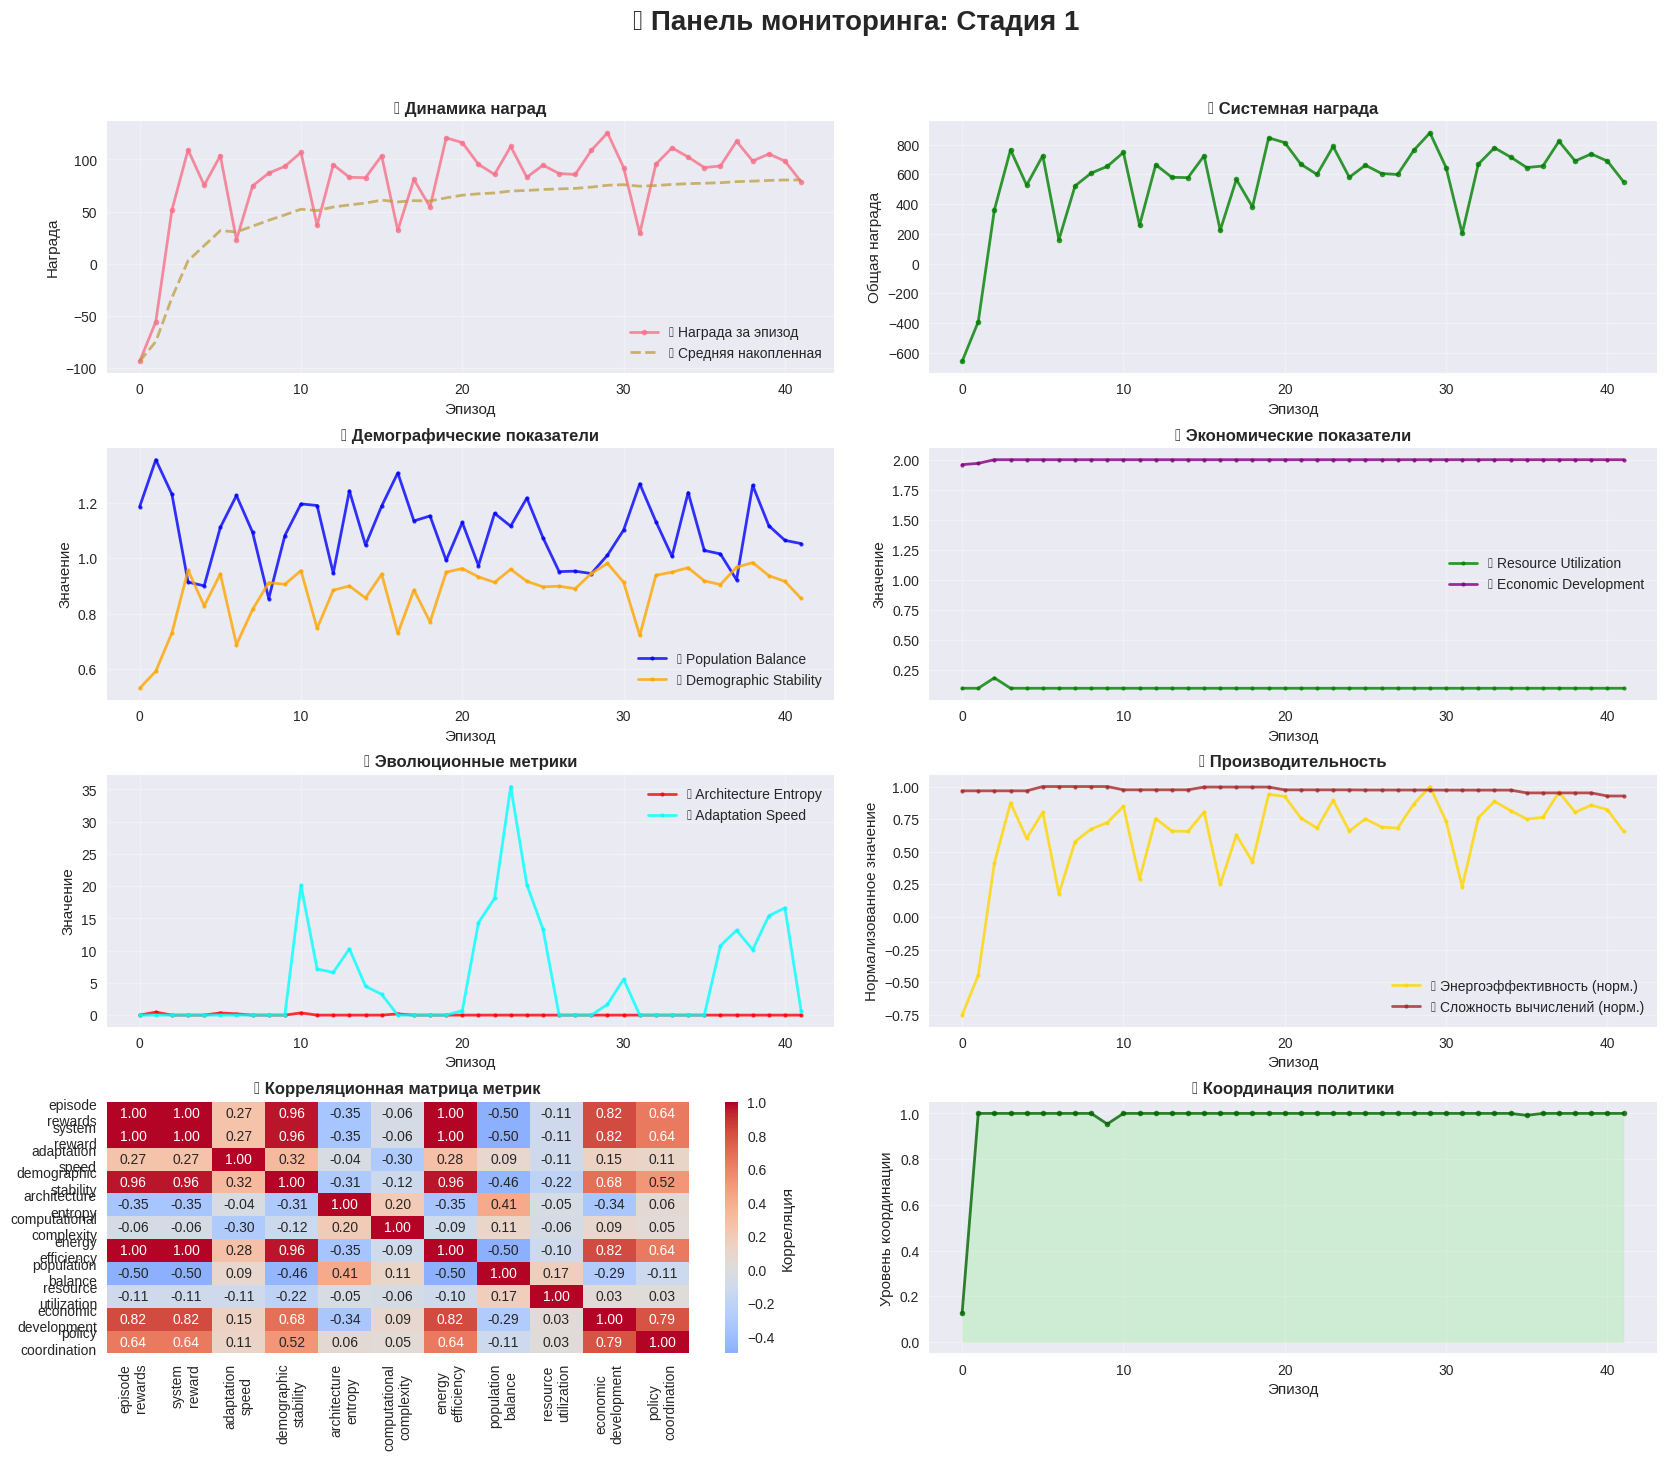


🧬 Создание анализа эволюции для Стадия 1...


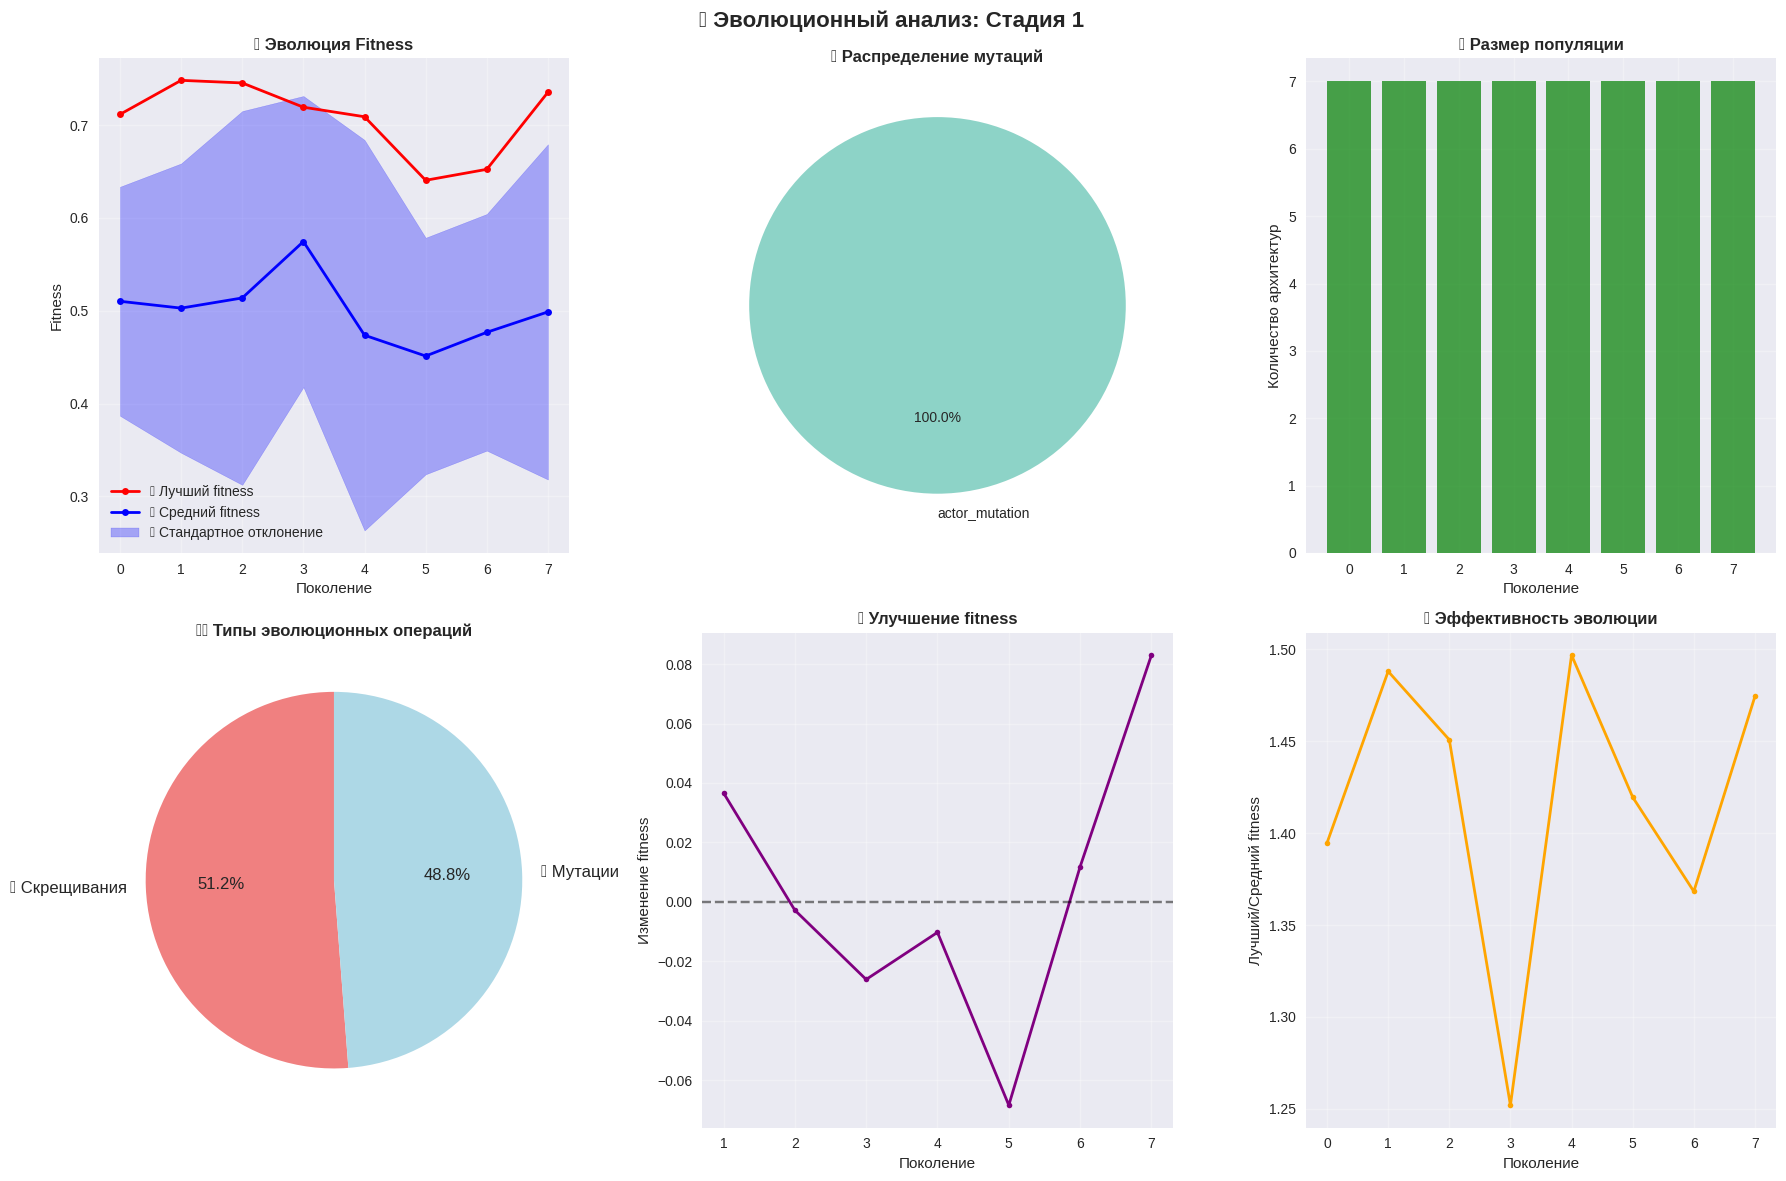

✅ Результаты стадии сохранены в: darwin_godel_results_20250611_162005/stage_стадия_1
✅ Стадия 1 завершена!

🥈 ПЕРЕХОД К СТАДИИ 2: Расширение до 28 регионов
💾 Директория сохранения: darwin_godel_results_20250611_162944

🚀 === Стадия 2 ===
🤖 Количество агентов: 28
📊 Количество эпизодов: 42

🎯 Начало стадии: Стадия 2
📅 Время начала: 16:29:44


🎯 Стадия 2:   0%|          | 0/42 [00:00<?, ?эпизод/s]

Эпизод 1:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 2:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 3:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 4:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 5:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 6:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 0)

🧬 --- Эволюция поколения 0 ---


🔄 Эволюция агентов:   0%|          | 0/28 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 16
🏆 Лучший fitness: 0.704
📊 Средний fitness: 0.135
📏 Стандартное отклонение: 0.531


Эпизод 7:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 8:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 9:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 10:   0%|          | 0/200 [00:00<?, ?шаг/s]


⏰ СТАТУС ВРЕМЕНИ ВЫПОЛНЕНИЯ
🖥️  Сессия Colab:
   Прошло времени: 13.4м
   Осталось времени: 11.8ч 47м
   Прогресс сессии: 1.9%

🎯 Текущая стадия: Стадия 2
   Прошло времени: 13.4м
   Осталось времени: 42.7м
   Эпизоды: 10/42
   Прогресс стадии: 23.8%


Эпизод 11:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 1)

🧬 --- Эволюция поколения 1 ---


🔄 Эволюция агентов:   0%|          | 0/28 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 15
🏆 Лучший fitness: 0.739
📊 Средний fitness: 0.199
📏 Стандартное отклонение: 0.584


Эпизод 12:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 13:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 14:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 15:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 16:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 2)

🧬 --- Эволюция поколения 2 ---


🔄 Эволюция агентов:   0%|          | 0/28 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 16
🏆 Лучший fitness: 0.719
📊 Средний fitness: 0.247
📏 Стандартное отклонение: 0.527


Эпизод 17:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 18:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 19:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 20:   0%|          | 0/200 [00:00<?, ?шаг/s]


⏰ СТАТУС ВРЕМЕНИ ВЫПОЛНЕНИЯ
🖥️  Сессия Colab:
   Прошло времени: 28.0м
   Осталось времени: 11.5ч 32м
   Прогресс сессии: 3.9%

🎯 Текущая стадия: Стадия 2
   Прошло времени: 28.0м
   Осталось времени: 30.8м
   Эпизоды: 20/42
   Прогресс стадии: 47.6%


Эпизод 21:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 3)

🧬 --- Эволюция поколения 3 ---


🔄 Эволюция агентов:   0%|          | 0/28 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 14
🏆 Лучший fitness: 0.745
📊 Средний fitness: 0.213
📏 Стандартное отклонение: 0.562


Эпизод 22:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 23:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 24:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 25:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 26:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 4)

🧬 --- Эволюция поколения 4 ---


🔄 Эволюция агентов:   0%|          | 0/28 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 17
🏆 Лучший fitness: 0.652
📊 Средний fitness: 0.211
📏 Стандартное отклонение: 0.524


Эпизод 27:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 28:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 29:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 30:   0%|          | 0/200 [00:00<?, ?шаг/s]


⏰ СТАТУС ВРЕМЕНИ ВЫПОЛНЕНИЯ
🖥️  Сессия Colab:
   Прошло времени: 42.5м
   Осталось времени: 11.3ч 17м
   Прогресс сессии: 5.9%

🎯 Текущая стадия: Стадия 2
   Прошло времени: 42.5м
   Осталось времени: 17.0м
   Эпизоды: 30/42
   Прогресс стадии: 71.4%


Эпизод 31:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 5)

🧬 --- Эволюция поколения 5 ---


🔄 Эволюция агентов:   0%|          | 0/28 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 15
🏆 Лучший fitness: 0.743
📊 Средний fitness: 0.287
📏 Стандартное отклонение: 0.614


Эпизод 32:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 33:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 34:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 35:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 36:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 6)

🧬 --- Эволюция поколения 6 ---


🔄 Эволюция агентов:   0%|          | 0/28 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 15
🏆 Лучший fitness: 0.733
📊 Средний fitness: 0.137
📏 Стандартное отклонение: 0.644


Эпизод 37:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 38:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 39:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 40:   0%|          | 0/200 [00:00<?, ?шаг/s]


⏰ СТАТУС ВРЕМЕНИ ВЫПОЛНЕНИЯ
🖥️  Сессия Colab:
   Прошло времени: 56.6м
   Осталось времени: 11.1ч 3м
   Прогресс сессии: 7.9%

🎯 Текущая стадия: Стадия 2
   Прошло времени: 56.6м
   Осталось времени: 2.8м
   Эпизоды: 40/42
   Прогресс стадии: 95.2%


Эпизод 41:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 7)

🧬 --- Эволюция поколения 7 ---


🔄 Эволюция агентов:   0%|          | 0/28 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 15
🏆 Лучший fitness: 0.745
📊 Средний fitness: 0.259
📏 Стандартное отклонение: 0.523


Эпизод 42:   0%|          | 0/200 [00:00<?, ?шаг/s]

✅ Стадия 'Стадия 2' завершена
⏱️ Длительность: 59.3м

💾 Сохранение результатов стадии: Стадия 2

💾 Сохранение результатов стадии: Стадия 2

📊 Создание панели мониторинга для Стадия 2...


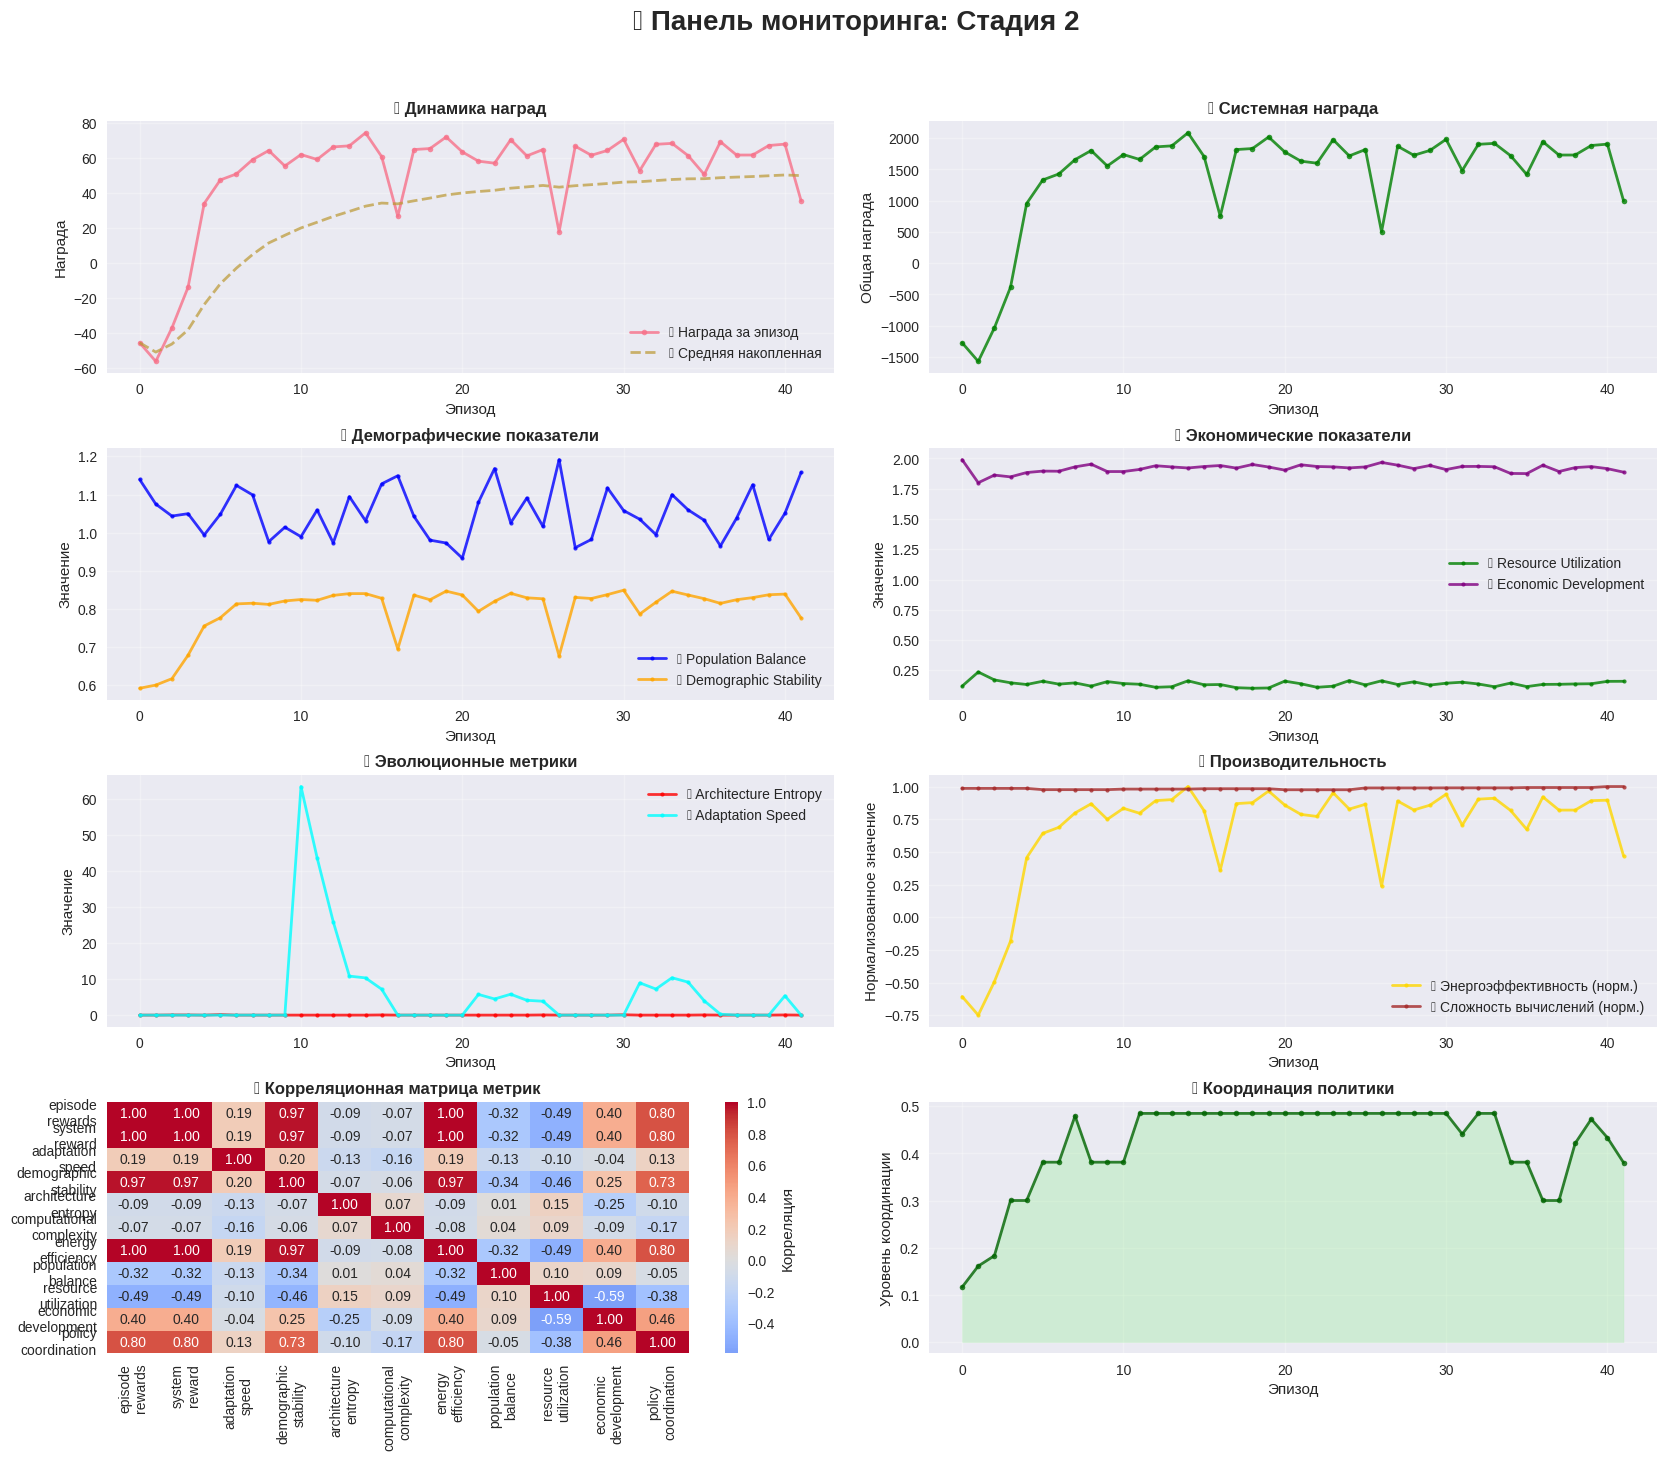


🧬 Создание анализа эволюции для Стадия 2...


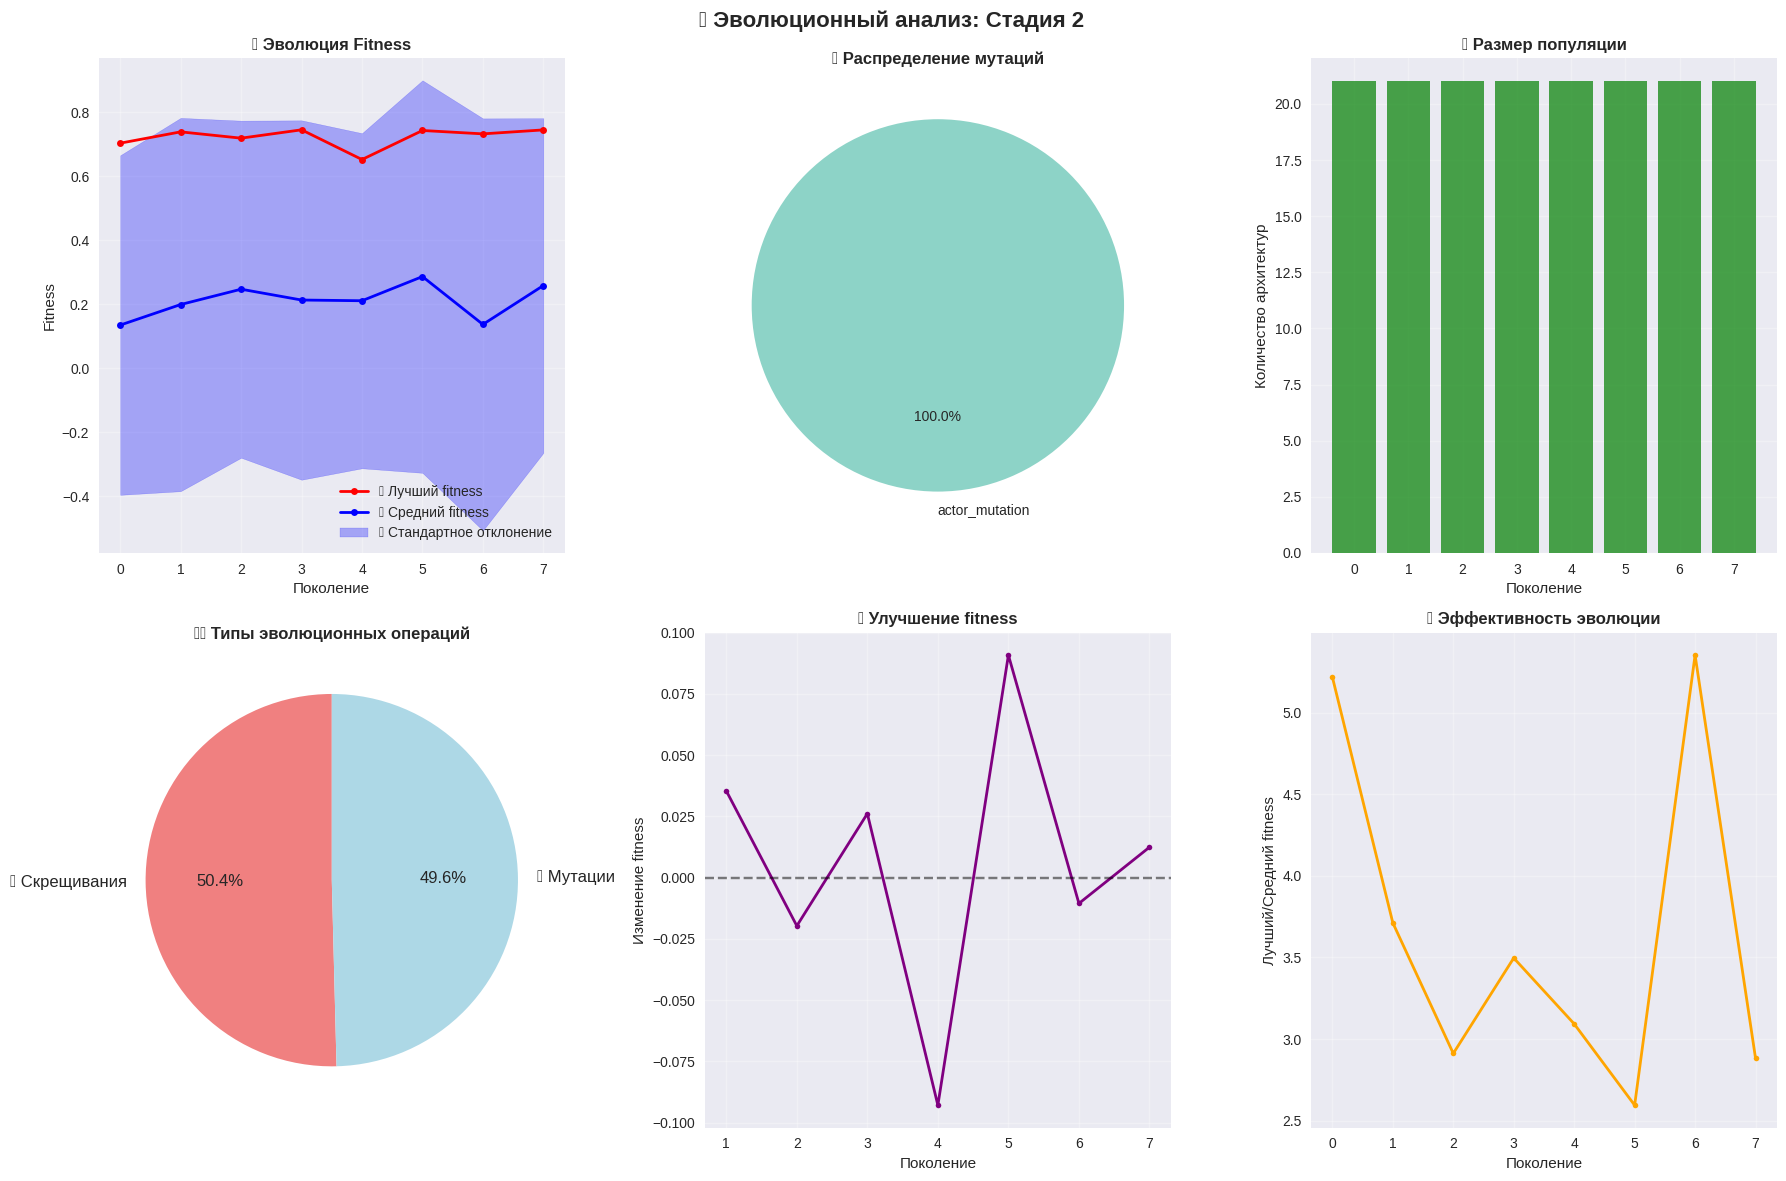

✅ Результаты стадии сохранены в: darwin_godel_results_20250611_162944/stage_стадия_2
✅ Стадия 2 завершена!

🥉 ПЕРЕХОД К СТАДИИ 3: Расширение до 89 регионов
💾 Директория сохранения: darwin_godel_results_20250611_172913

🚀 === Стадия 3 ===
🤖 Количество агентов: 89
📊 Количество эпизодов: 42

🎯 Начало стадии: Стадия 3
📅 Время начала: 17:29:13


🎯 Стадия 3:   0%|          | 0/42 [00:00<?, ?эпизод/s]

Эпизод 1:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 2:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 3:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 4:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 5:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 6:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 0)

🧬 --- Эволюция поколения 0 ---


🔄 Эволюция агентов:   0%|          | 0/89 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 46
🏆 Лучший fitness: 0.688
📊 Средний fitness: -0.337
📏 Стандартное отклонение: 0.646


Эпизод 7:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 8:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 9:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 10:   0%|          | 0/200 [00:00<?, ?шаг/s]


⏰ СТАТУС ВРЕМЕНИ ВЫПОЛНЕНИЯ
🖥️  Сессия Colab:
   Прошло времени: 1.5ч 31м
   Осталось времени: 10.5ч 29м
   Прогресс сессии: 12.6%

🎯 Текущая стадия: Стадия 3
   Прошло времени: 1.5ч 31м
   Осталось времени: 4.8ч 51м
   Эпизоды: 10/42
   Прогресс стадии: 23.8%


Эпизод 11:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 1)

🧬 --- Эволюция поколения 1 ---


🔄 Эволюция агентов:   0%|          | 0/89 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 50
🏆 Лучший fitness: 0.743
📊 Средний fitness: -0.223
📏 Стандартное отклонение: 0.681


Эпизод 12:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 13:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 14:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 15:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 16:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 2)

🧬 --- Эволюция поколения 2 ---


🔄 Эволюция агентов:   0%|          | 0/89 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 50
🏆 Лучший fitness: 0.743
📊 Средний fitness: -0.083
📏 Стандартное отклонение: 0.683


Эпизод 17:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 18:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 19:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 20:   0%|          | 0/200 [00:00<?, ?шаг/s]


⏰ СТАТУС ВРЕМЕНИ ВЫПОЛНЕНИЯ
🖥️  Сессия Colab:
   Прошло времени: 3.1ч 4м
   Осталось времени: 8.9ч 56м
   Прогресс сессии: 25.6%

🎯 Текущая стадия: Стадия 3
   Прошло времени: 3.1ч 4м
   Осталось времени: 3.4ч 23м
   Эпизоды: 20/42
   Прогресс стадии: 47.6%


Эпизод 21:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 3)

🧬 --- Эволюция поколения 3 ---


🔄 Эволюция агентов:   0%|          | 0/89 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 56
🏆 Лучший fitness: 0.747
📊 Средний fitness: -0.013
📏 Стандартное отклонение: 0.694


Эпизод 22:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 23:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 24:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 25:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 26:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 4)

🧬 --- Эволюция поколения 4 ---


🔄 Эволюция агентов:   0%|          | 0/89 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 49
🏆 Лучший fitness: 0.737
📊 Средний fitness: -0.011
📏 Стандартное отклонение: 0.613


Эпизод 27:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 28:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 29:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 30:   0%|          | 0/200 [00:00<?, ?шаг/s]


⏰ СТАТУС ВРЕМЕНИ ВЫПОЛНЕНИЯ
🖥️  Сессия Colab:
   Прошло времени: 4.7ч 40м
   Осталось времени: 7.3ч 20м
   Прогресс сессии: 39.0%

🎯 Текущая стадия: Стадия 3
   Прошло времени: 4.7ч 40м
   Осталось времени: 1.9ч 52м
   Эпизоды: 30/42
   Прогресс стадии: 71.4%


Эпизод 31:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 5)

🧬 --- Эволюция поколения 5 ---


🔄 Эволюция агентов:   0%|          | 0/89 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 48
🏆 Лучший fitness: 0.735
📊 Средний fitness: -0.006
📏 Стандартное отклонение: 0.652


Эпизод 32:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 33:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 34:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 35:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 36:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 6)

🧬 --- Эволюция поколения 6 ---


🔄 Эволюция агентов:   0%|          | 0/89 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 54
🏆 Лучший fitness: 0.739
📊 Средний fitness: -0.020
📏 Стандартное отклонение: 0.696


Эпизод 37:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 38:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 39:   0%|          | 0/200 [00:00<?, ?шаг/s]

Эпизод 40:   0%|          | 0/200 [00:00<?, ?шаг/s]


⏰ СТАТУС ВРЕМЕНИ ВЫПОЛНЕНИЯ
🖥️  Сессия Colab:
   Прошло времени: 6.3ч 19м
   Осталось времени: 5.7ч 41м
   Прогресс сессии: 52.6%

🎯 Текущая стадия: Стадия 3
   Прошло времени: 6.3ч 19м
   Осталось времени: 18.9м
   Эпизоды: 40/42
   Прогресс стадии: 95.2%


Эпизод 41:   0%|          | 0/200 [00:00<?, ?шаг/s]


🧬 Эволюция архитектур (поколение 7)

🧬 --- Эволюция поколения 7 ---


🔄 Эволюция агентов:   0%|          | 0/89 [00:00<?, ?it/s]

✨ Эволюционировало агентов: 42
🏆 Лучший fitness: 0.734
📊 Средний fitness: -0.019
📏 Стандартное отклонение: 0.688


Эпизод 42:   0%|          | 0/200 [00:00<?, ?шаг/s]

✅ Стадия 'Стадия 3' завершена
⏱️ Длительность: 6.6ч 39м

💾 Сохранение результатов стадии: Стадия 3

💾 Сохранение результатов стадии: Стадия 3

📊 Создание панели мониторинга для Стадия 3...


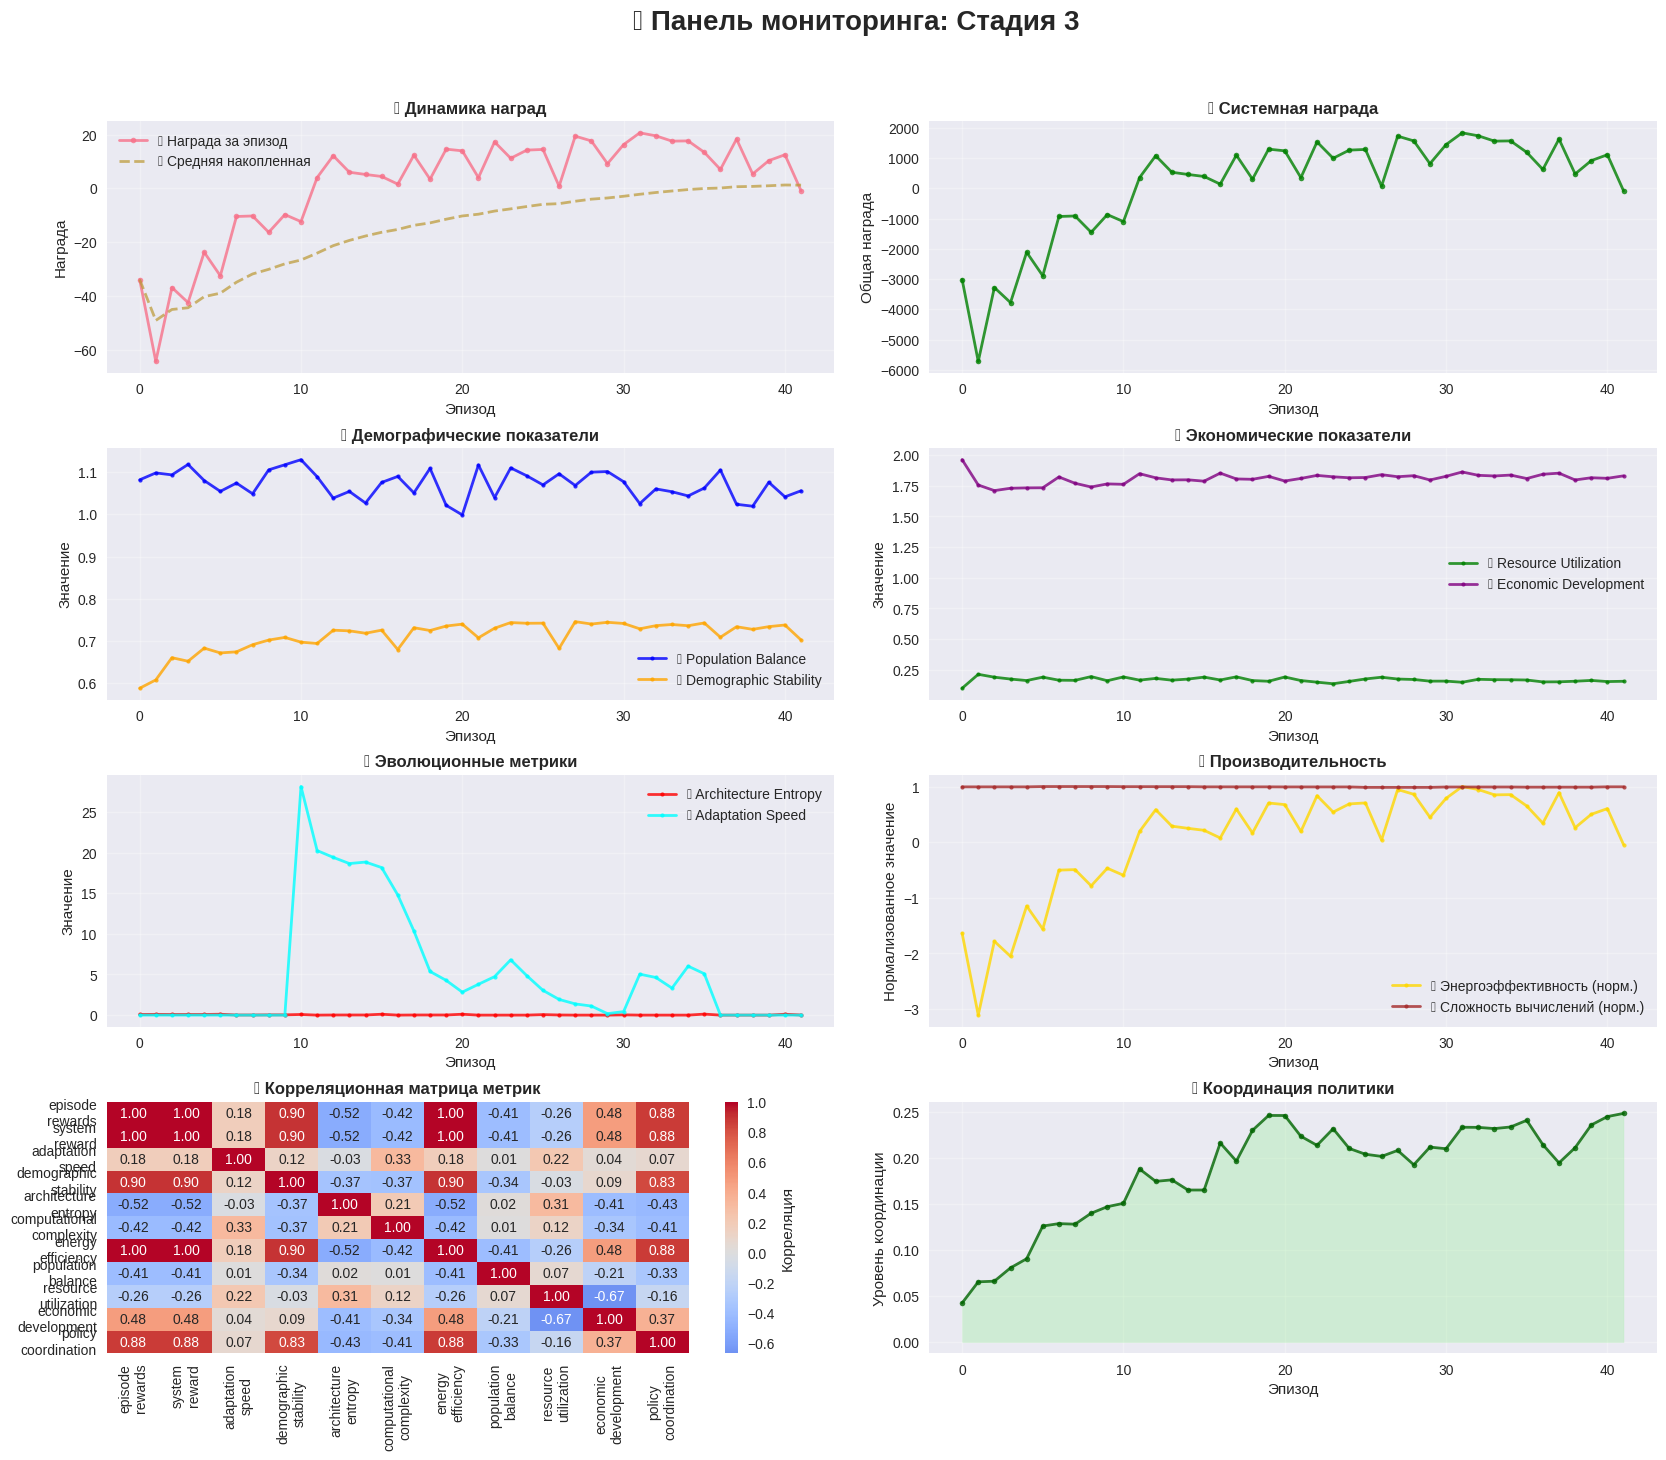


🧬 Создание анализа эволюции для Стадия 3...


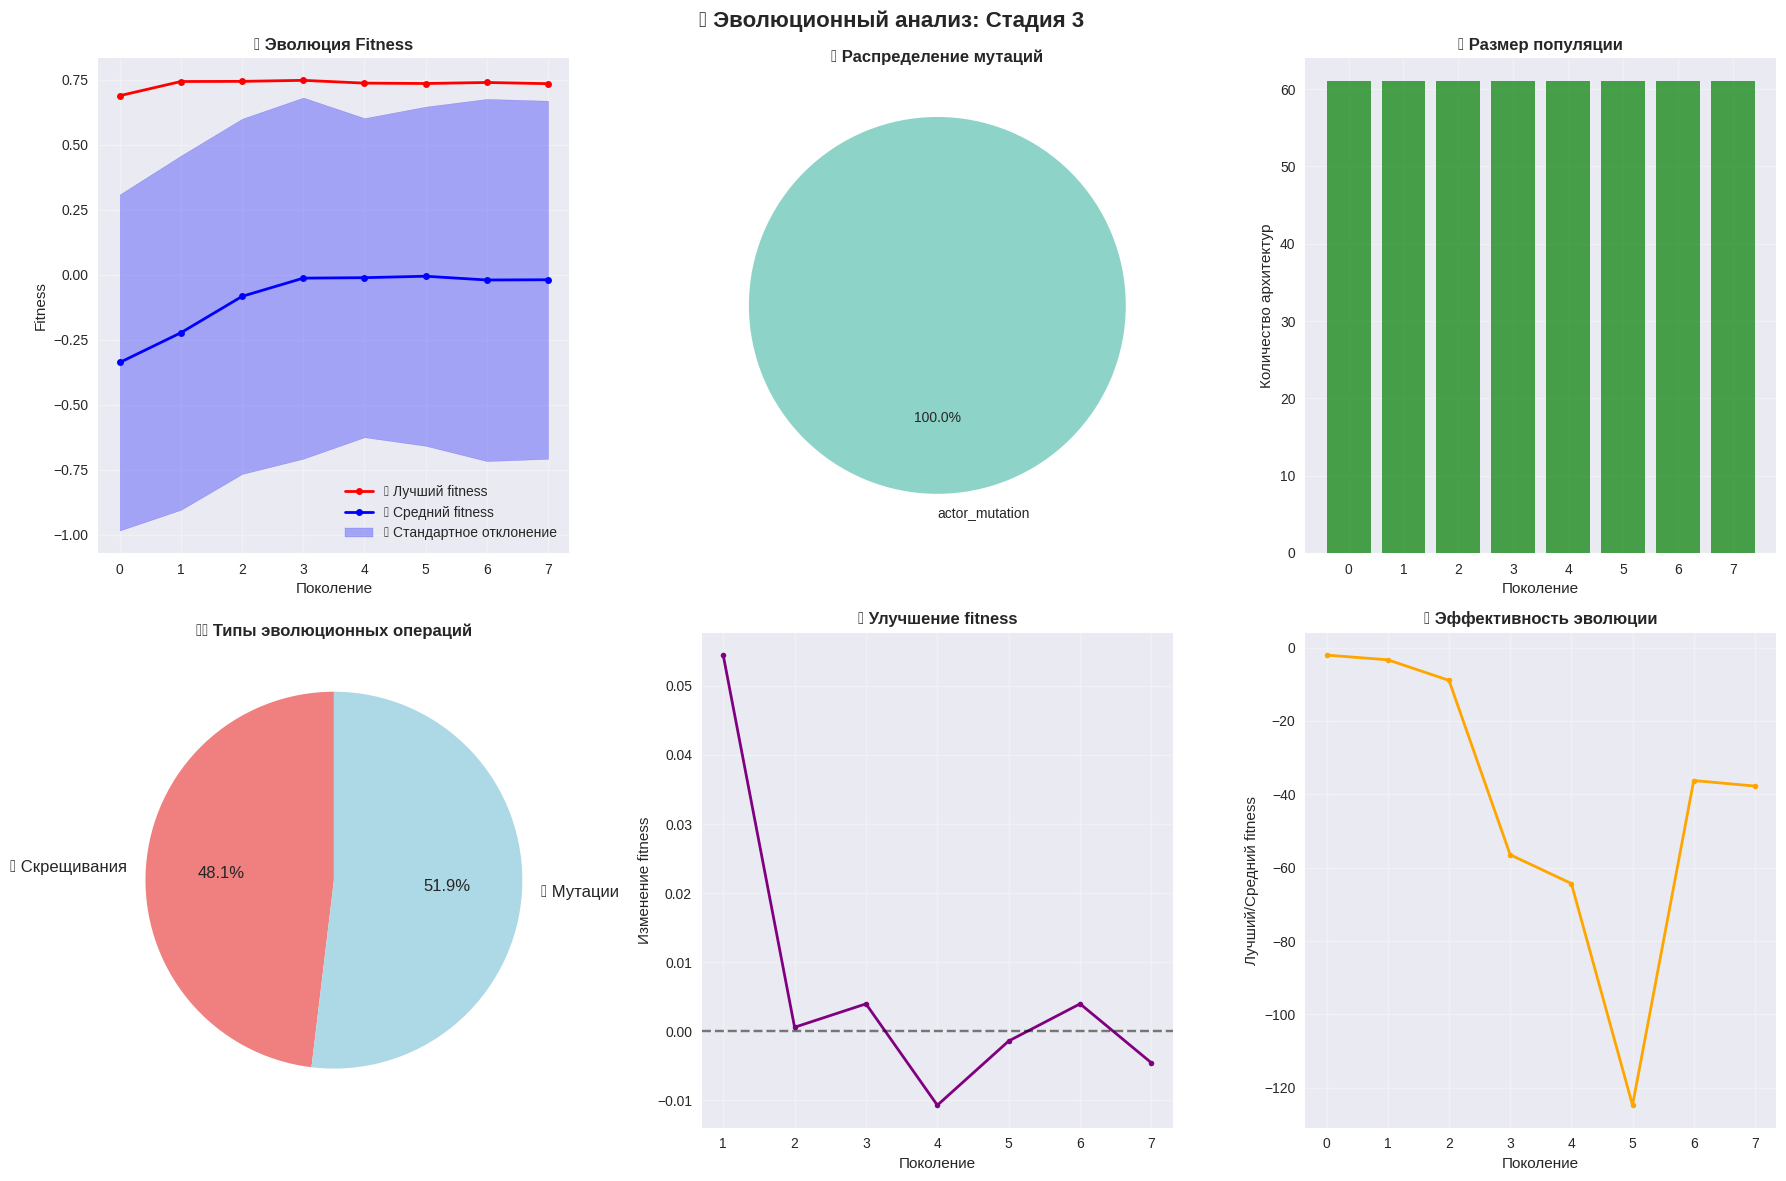

✅ Результаты стадии сохранены в: darwin_godel_results_20250611_172913/stage_стадия_3
✅ Стадия 3 завершена!

📋 Создание финального отчета...
📋 Финальный отчет сохранен: darwin_godel_results_20250611_172913/FINAL_REPORT.txt

🎉 ========== ОБУЧЕНИЕ УСПЕШНО ЗАВЕРШЕНО! ==========

🎉 ========== ЭКСПЕРИМЕНТ УСПЕШНО ЗАВЕРШЕН! ==========
💾 Все результаты сохранены в: darwin_godel_results_20250611_172913
📊 Проверьте созданные графики и отчеты для анализа результатов


In [9]:
# ===== ЗАПУСК ОПТИМИЗИРОВАННОГО ЭКСПЕРИМЕНТА =====
if __name__ == "__main__":
    print("\n🚀 ========== ЗАПУСК ОПТИМИЗИРОВАННОГО ЭКСПЕРИМЕНТА ==========")
    print("🎯 Darwin Gödel MADDPG v2.0 - Система управления демографическими процессами")
    print("⚡ Оптимизировано для Google Colab T4 GPU")
    print("🔧 Включены: мониторинг времени, автосохранение, расширенная визуализация")
    print("="*80)

    # Отображение информации о системе
    print(f"\n💻 ИНФОРМАЦИЯ О СИСТЕМЕ:")
    print(f"🖥️  Устройство: {device}")
    if torch.cuda.is_available():
        print(f"🔧 GPU: {torch.cuda.get_device_name(0)}")
        print(f"💾 Доступная память GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"🐍 PyTorch версия: {torch.__version__}")
    print(f"🧠 cuDNN автотюнер: {'Включен' if torch.backends.cudnn.benchmark else 'Отключен'}")

    # Создание и запуск системы
    print(f"\n🏗️ Инициализация системы...")
    system = DarwinGodelMADDPG()

    try:
        # Отображение стартовой информации о времени
        system.time_tracker.display_status()

        # Запуск полного обучения
        system.train_all_stages()

        print("\n🎉 ========== ЭКСПЕРИМЕНТ УСПЕШНО ЗАВЕРШЕН! ==========")
        print(f"💾 Все результаты сохранены в: {system.save_manager.session_dir}")
        print("📊 Проверьте созданные графики и отчеты для анализа результатов")

    except KeyboardInterrupt:
        print("\n⏸️ ========== ЭКСПЕРИМЕНТ ПРЕРВАН ПОЛЬЗОВАТЕЛЕМ ==========")
        print("💾 Сохраняю промежуточные результаты...")
        system.save_manager.save_stage_results(
            "interrupted_save", system, system.performance_monitor,
            system.evolution_logger, system.time_tracker, system.visualizer
        )
        print("✅ Промежуточные результаты сохранены")

    except Exception as e:
        print(f"\n❌ ========== ОШИБКА В ЭКСПЕРИМЕНТЕ ==========")
        print(f"💥 Ошибка: {e}")
        print("💾 Сохраняю результаты для отладки...")
        system.save_manager.save_stage_results(
            "error_save", system, system.performance_monitor,
            system.evolution_logger, system.time_tracker, system.visualizer
        )
        print("✅ Результаты для отладки сохранены")
        raise

    finally:
        # Очистка ресурсов GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            print("🧹 Кэш GPU очищен")